In [1]:
import sys
if "/rhome/naotok/.local/lib/python3.10/site-packages" in sys.path:
    sys.path.remove("/rhome/naotok/.local/lib/python3.10/site-packages")

In [2]:
# import library
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 1000)
import scanpy as sc
sc.set_figure_params(dpi_save = 1000, dpi = 200)
import anndata as ad
import matplotlib
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/msttcorefonts/Arial.ttf')
from matplotlib import rcParams
rcParams["font.family"] = "Arial"
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io
import scrublet as scr

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.10.8
scanpy      1.9.5
-----
PIL                 9.2.0
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.5
cffi                1.15.1
cloudpickle         2.2.0
colorama            0.4.5
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2022.9.2
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
defusedxml          0.7.1
dill                0.3.5.1
entrypoints         0.4
exceptiongroup      1.2.2
executing           1.1.1
fsspec              2022.8.2
google              NA
h5py                3.7.0
hypergeom_ufunc     NA
igraph              0.10.8
ipykernel           6.16.0
ipython_genutils    0.2.0
ipywidgets          8.0.2
jedi                0.18.1
jinja2              3.1.2
joblib              1.2.0
jupyter_server      1.21.0
kiwisolver          1.4.4
leidenalg           0.10.1
llvmlite            0.39.1
lz4               

In [ ]:
%matplotlib inline
# Set workdir
workdir = "/rhome/naotok/bigdata/Aldh1l1Cre/kb-nac"
results_file = workdir + "/scanpy/results.h5ad"
main_file =  workdir + "/scanpy/main.h5ad"
sc.settings.figdir = workdir + "/scanpy/figures"
sc.settings.cachedir = workdir + "/scanpy/cache"

In [4]:
# Load preprocessed data
adata = sc.read_h5ad(
    results_file
)
adata.uns['log1p']["base"] = None

In [5]:
adata.obs['batch'] = adata.obs['batch'].map(lambda x: 'Control' if x == 'WT' else 'Ptbp1 cKO')
adata.obs['batch_short'] = adata.obs['batch'].map(lambda x: 'Ctrl' if x == 'Control' else 'cKO')

In [6]:
# Number of cells
print(adata.obs.groupby("batch").size())

batch
Control      10851
Ptbp1 cKO     8594
dtype: int64


# Plot

In [7]:
np.random.seed(0)
random_indices = np.random.permutation(list(range(adata.shape[0])))

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


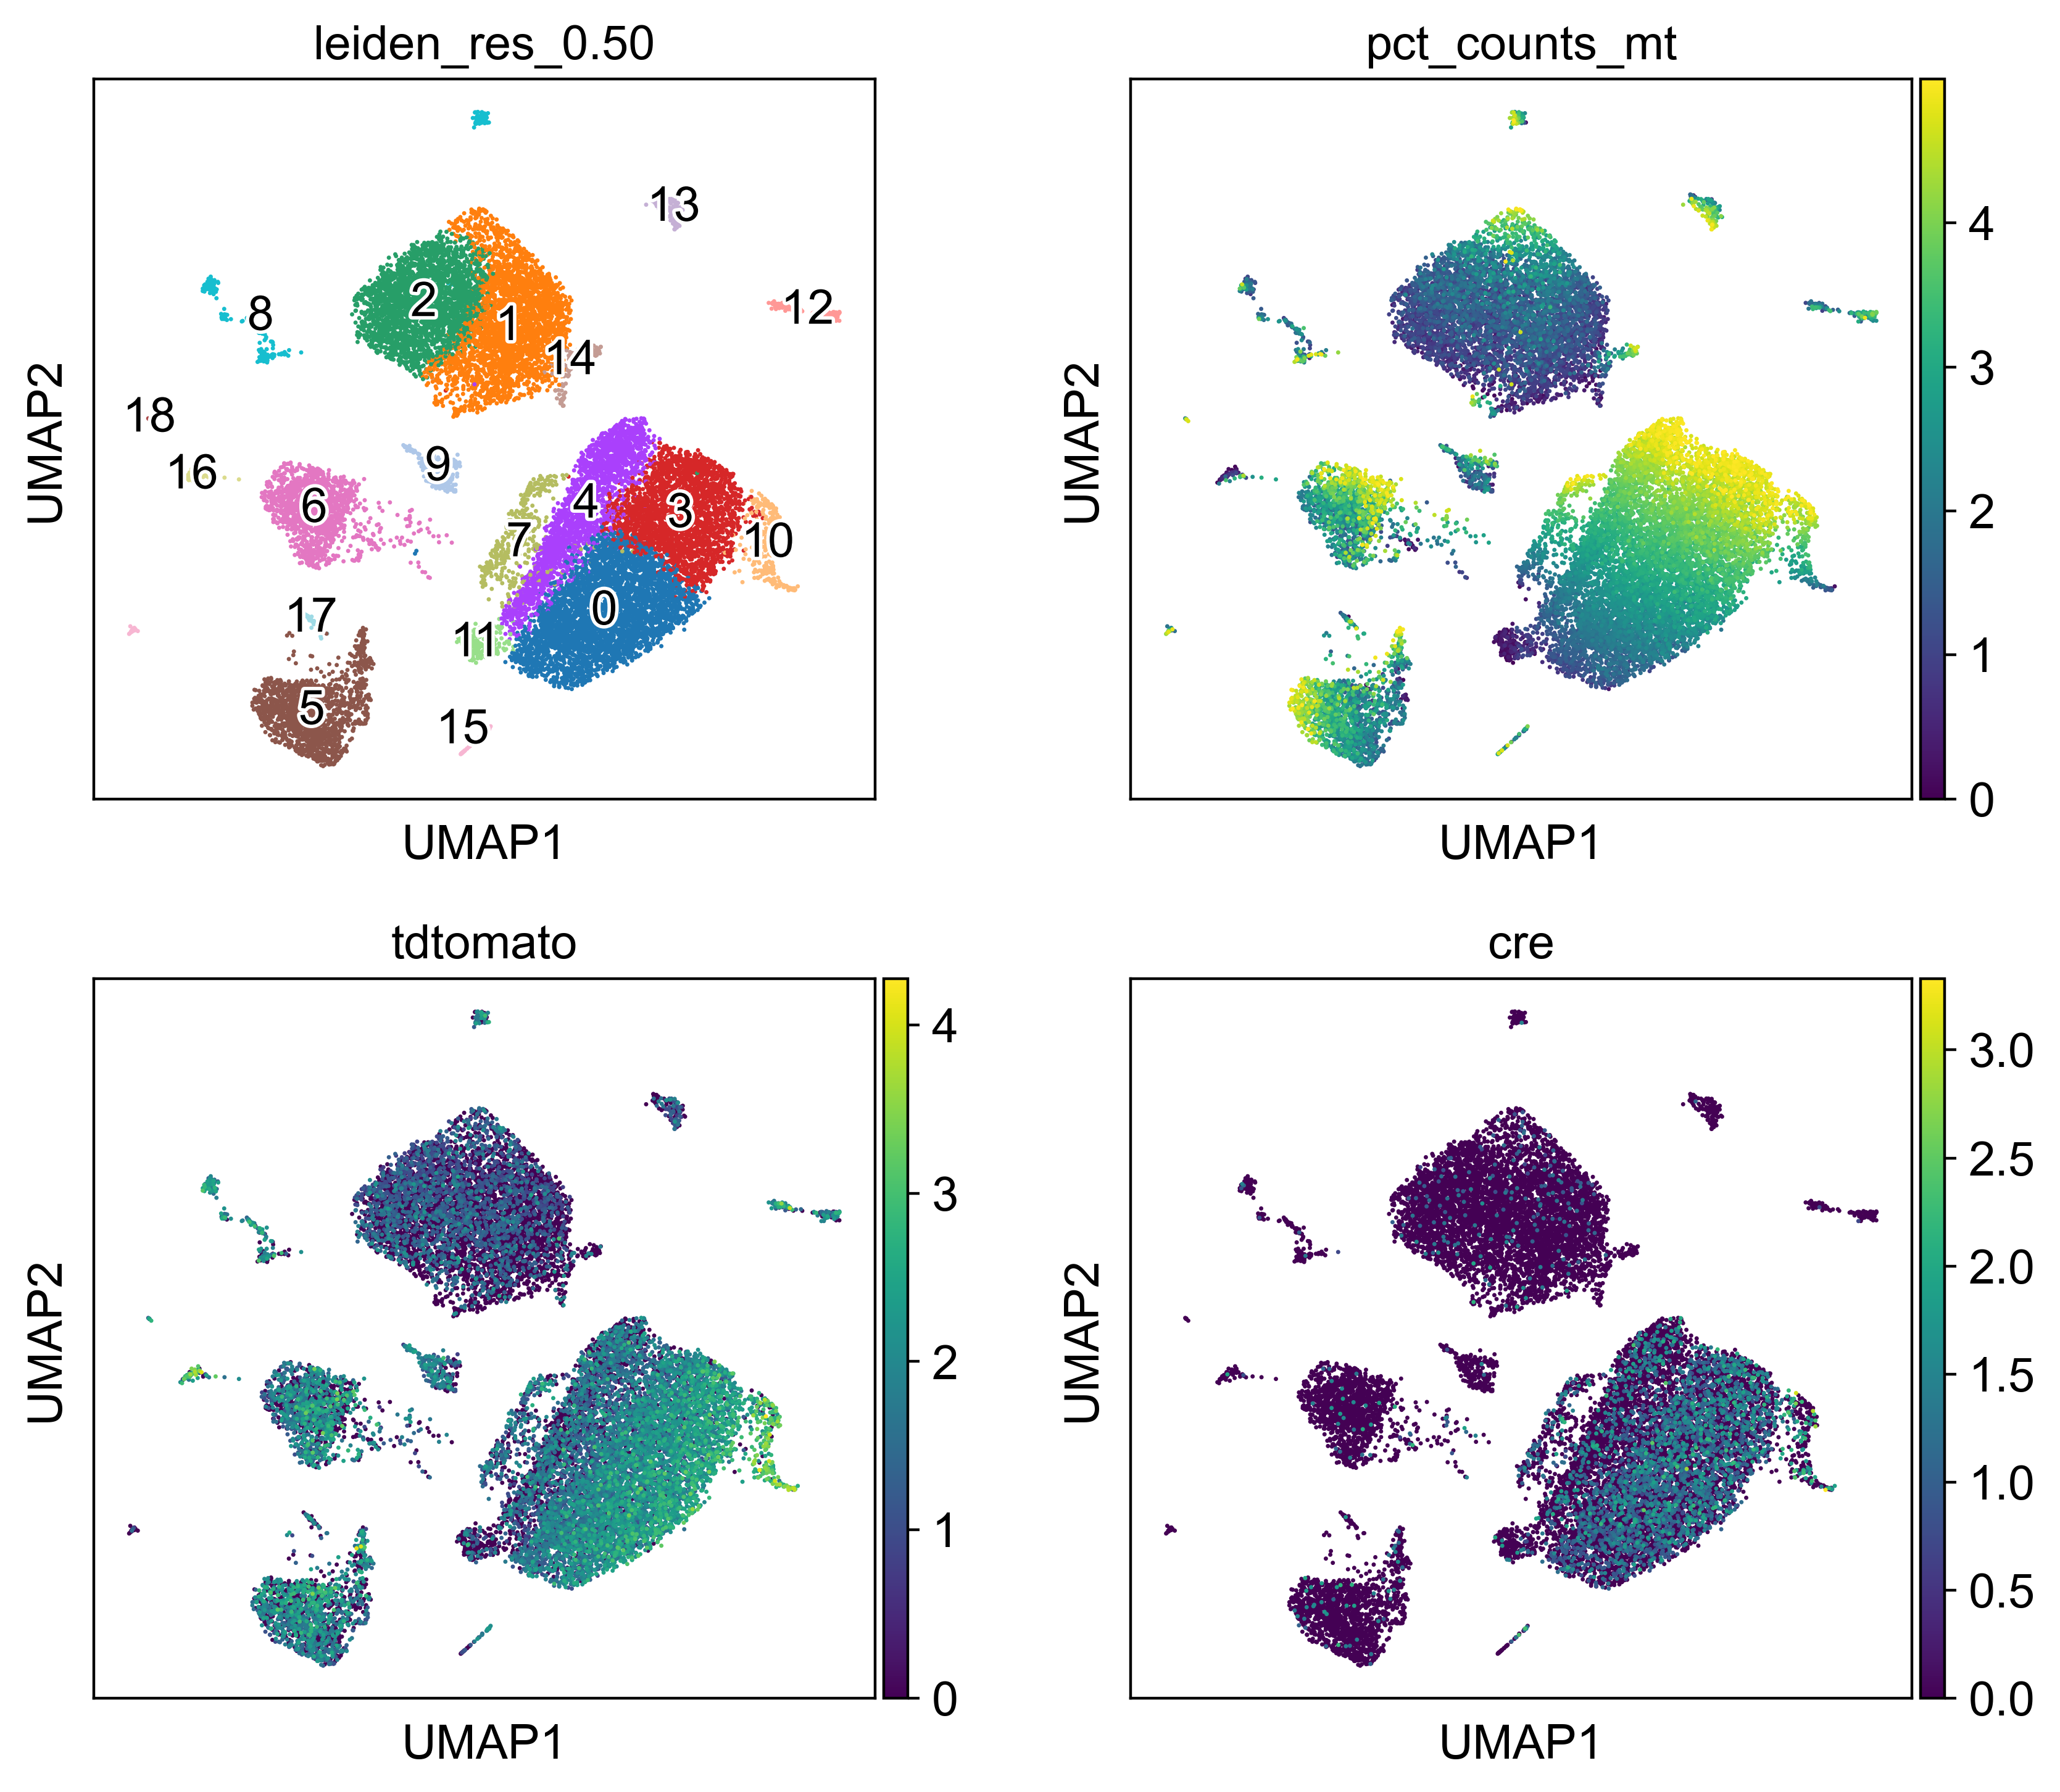

In [8]:
sc.pl.umap(
    adata[random_indices, :],
    color=["leiden_res_0.50", "pct_counts_mt", "tdtomato", "cre"],
    legend_loc="on data",
    ncols = 2,
    legend_fontoutline = 2,
    save = "_leiden_res_harmony_qc"
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


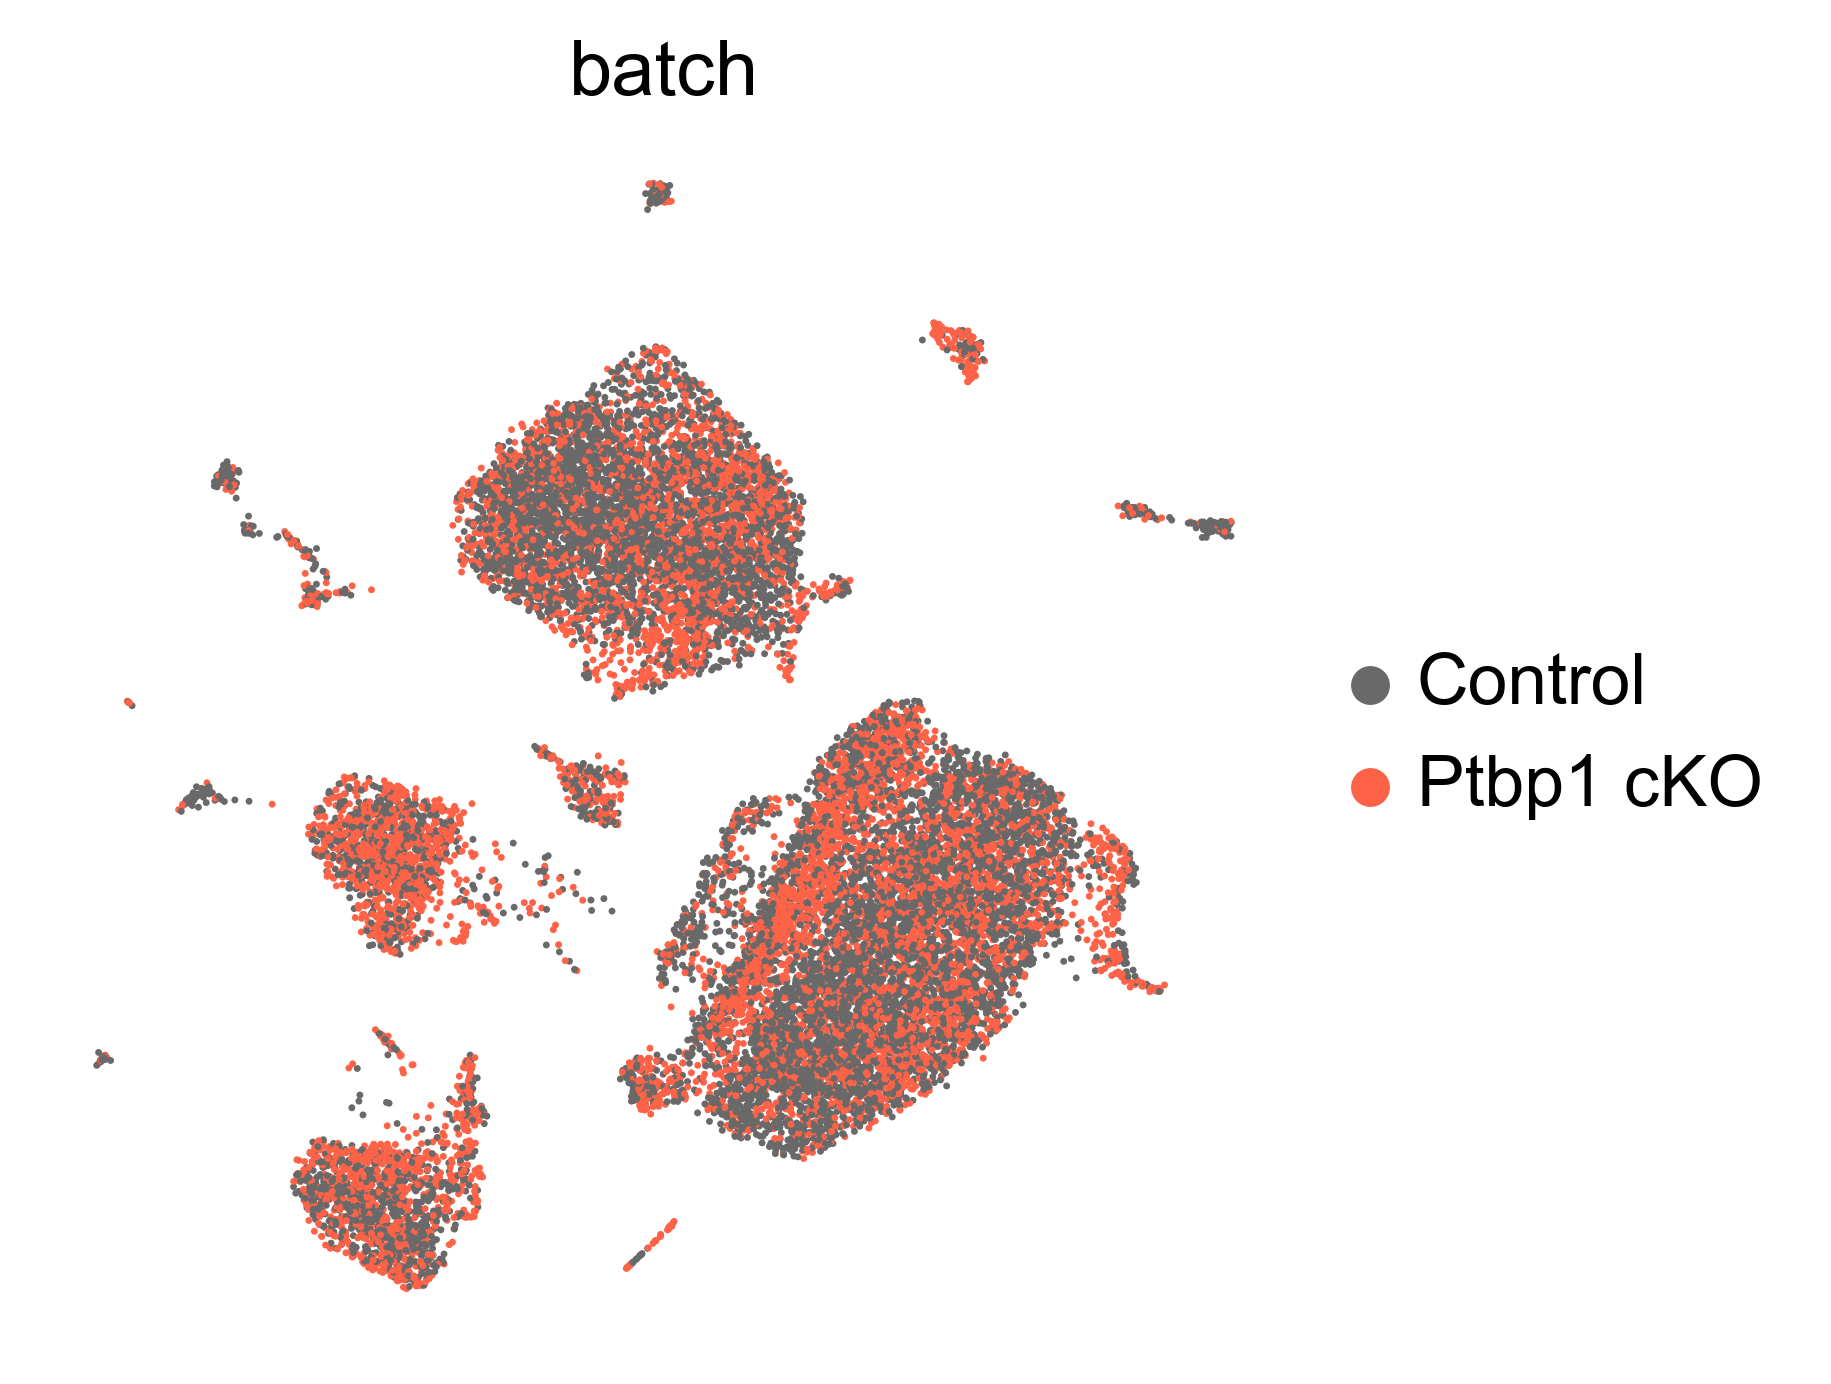

In [10]:
sc.pl.umap(
    adata[random_indices, :],
    color=["batch"],
    frameon=False,
    palette = {"Control": "dimgray", "Ptbp1 cKO": "tomato"},
    save = "_WTvsKO.png"
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


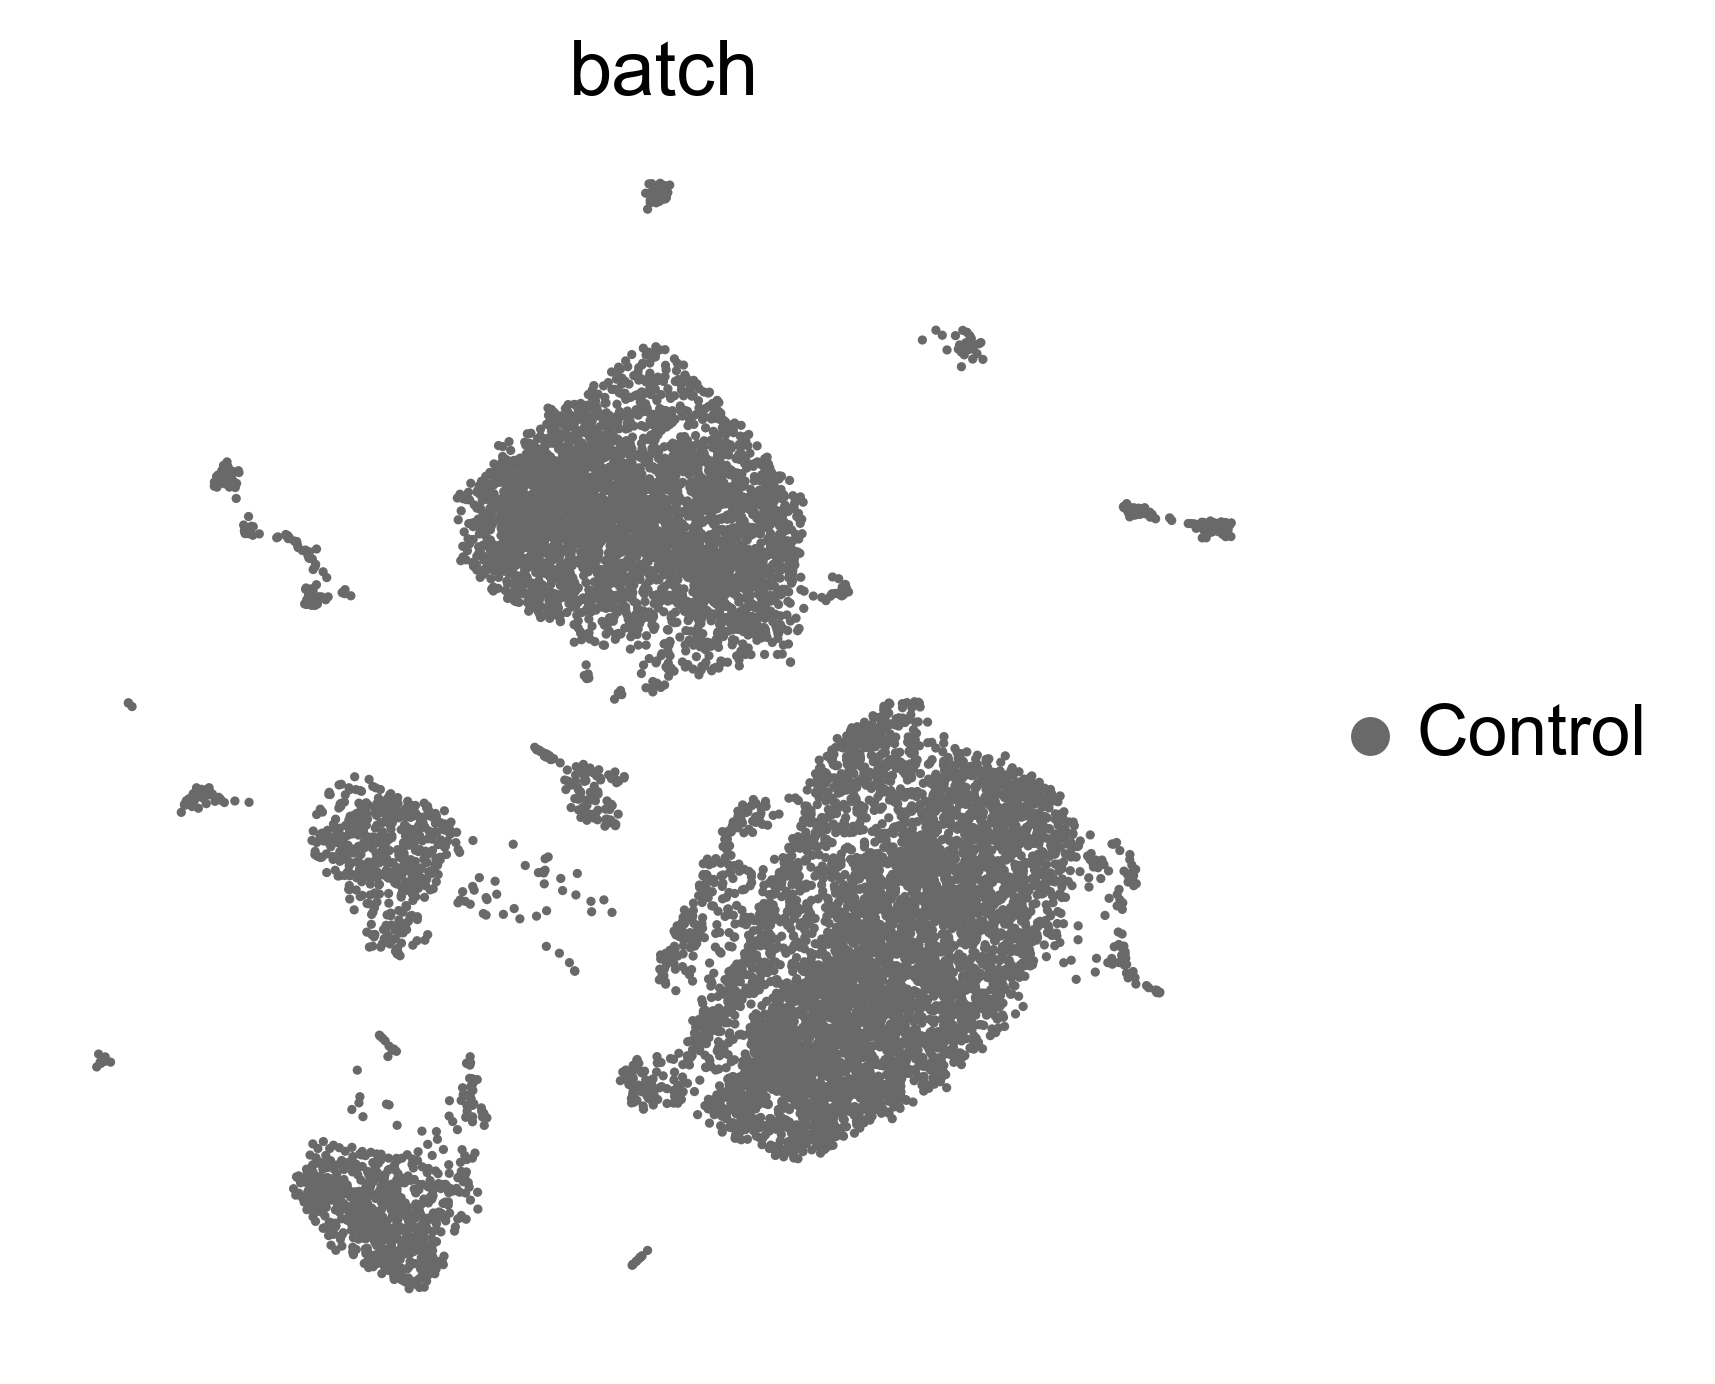

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


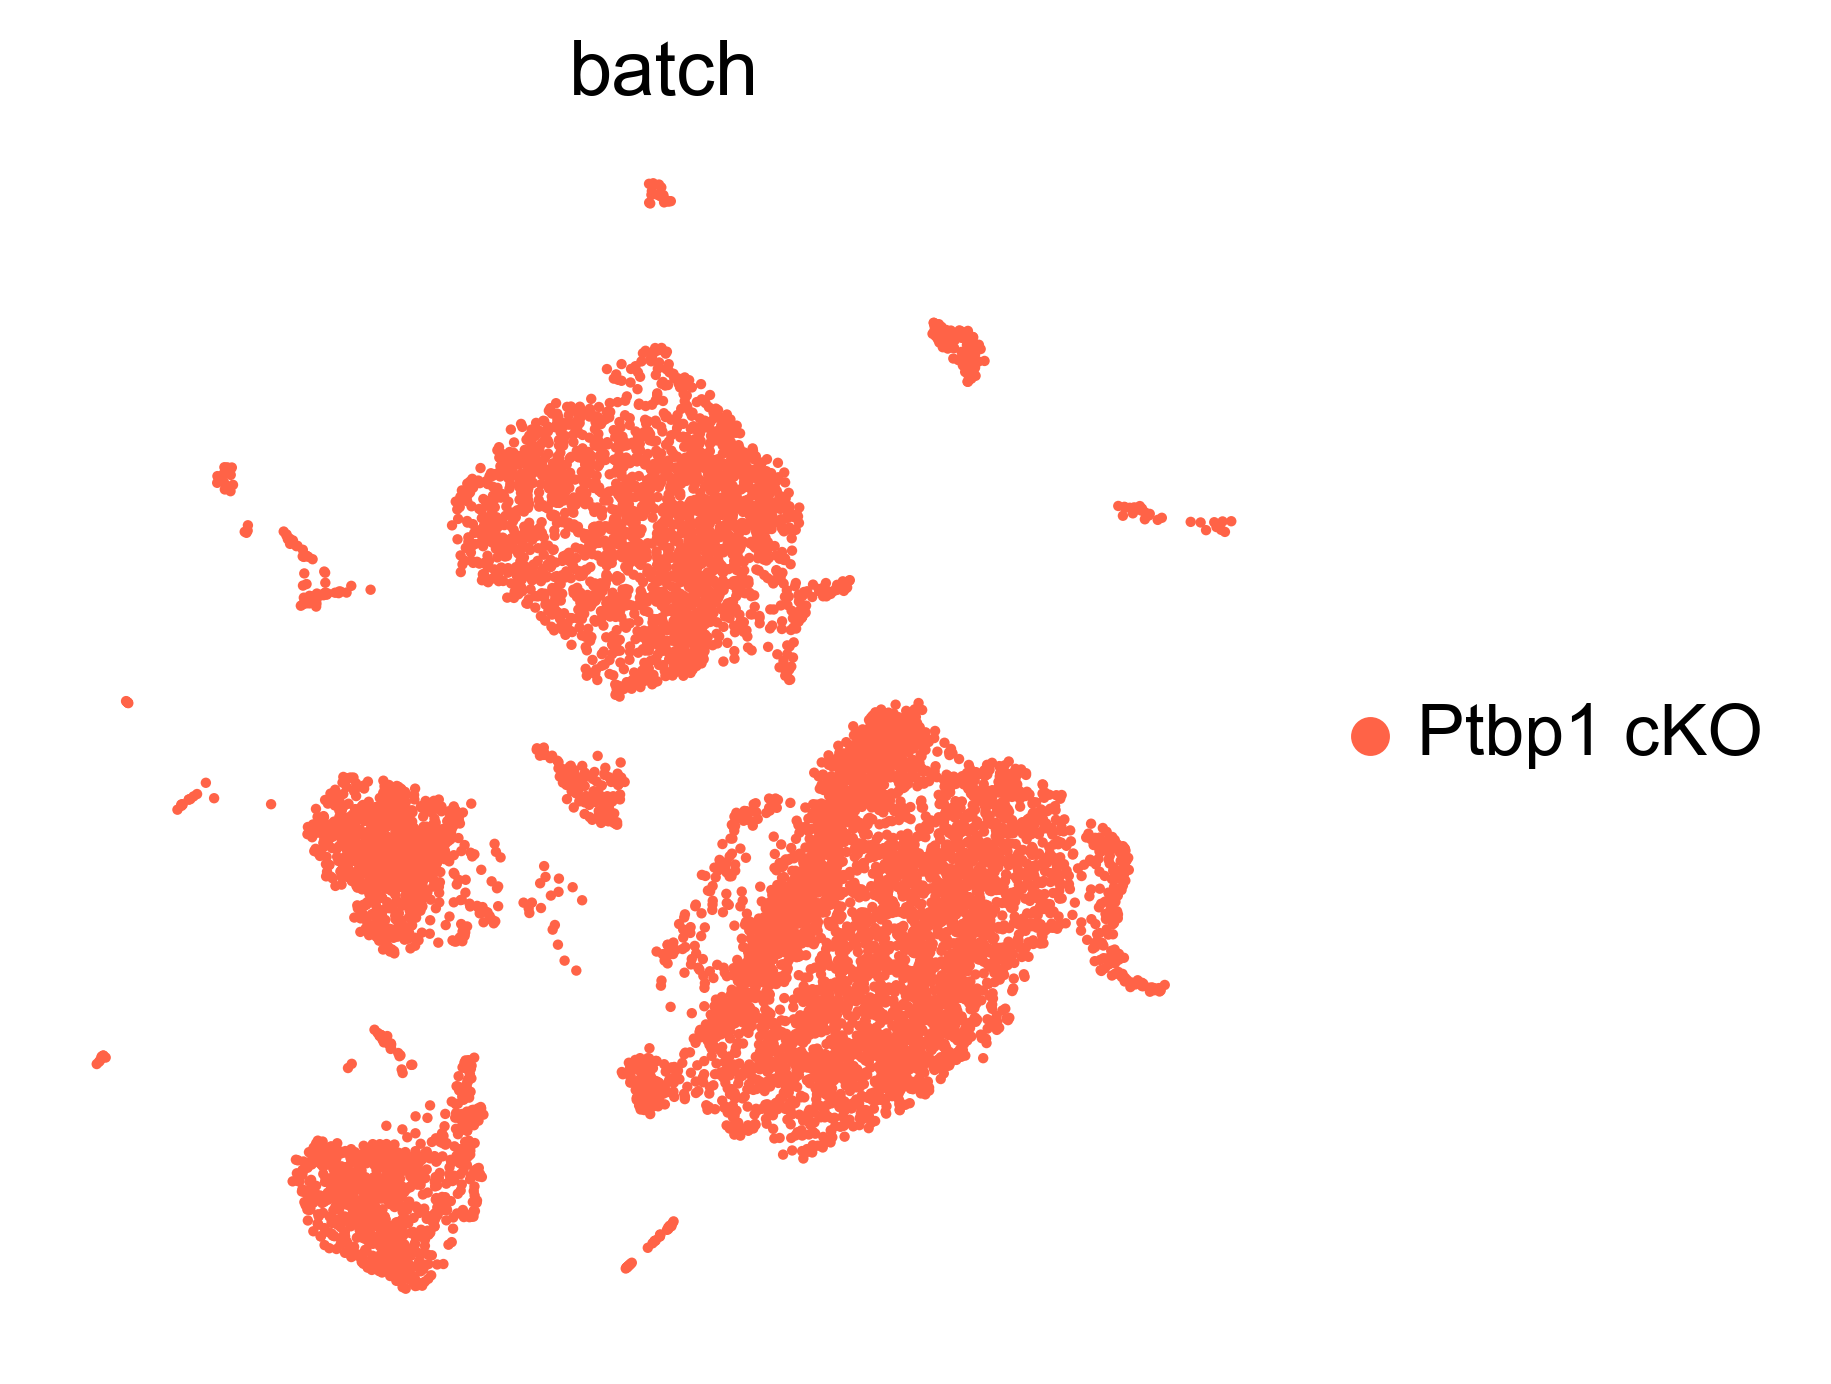

In [11]:
batch_palette = {"Control": "dimgray", "Ptbp1 cKO": "tomato"}
for batch in batch_palette:
    adata_batch = adata[adata.obs["batch"] == batch,]
    sc.pl.umap(
        adata_batch,
        frameon = False,
        color = ["batch"],
        palette = batch_palette,
        save = "_" + batch + ".png"
    )

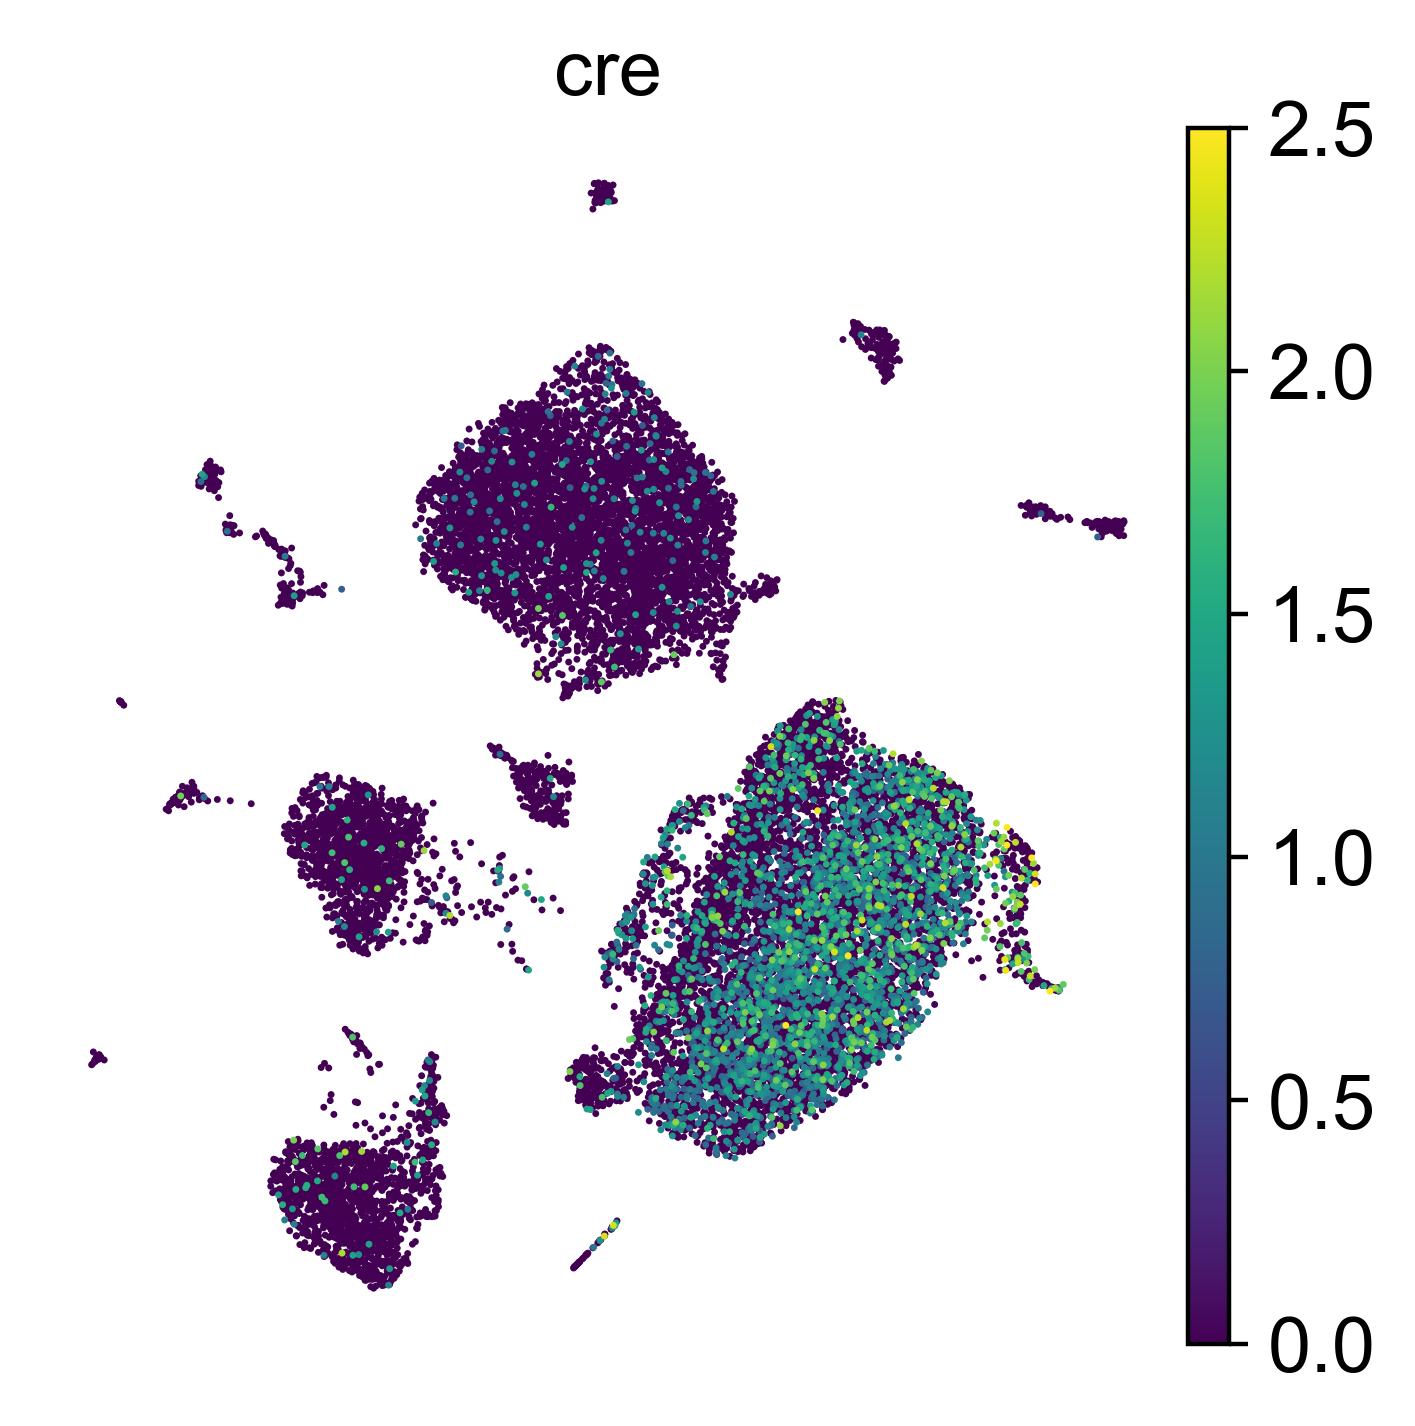

In [17]:
# Astrocyte markers
sc.pl.umap(
    adata[random_indices, :],
    color=["cre"],
#     legend_loc="on data",
    frameon=False,
    cmap = "viridis",
    vmax = 2.5,
    save = "_Cre.png"
)

# Differentially-expressed Genes as Markers

In [18]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.50", method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:29)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res_0.50']`


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


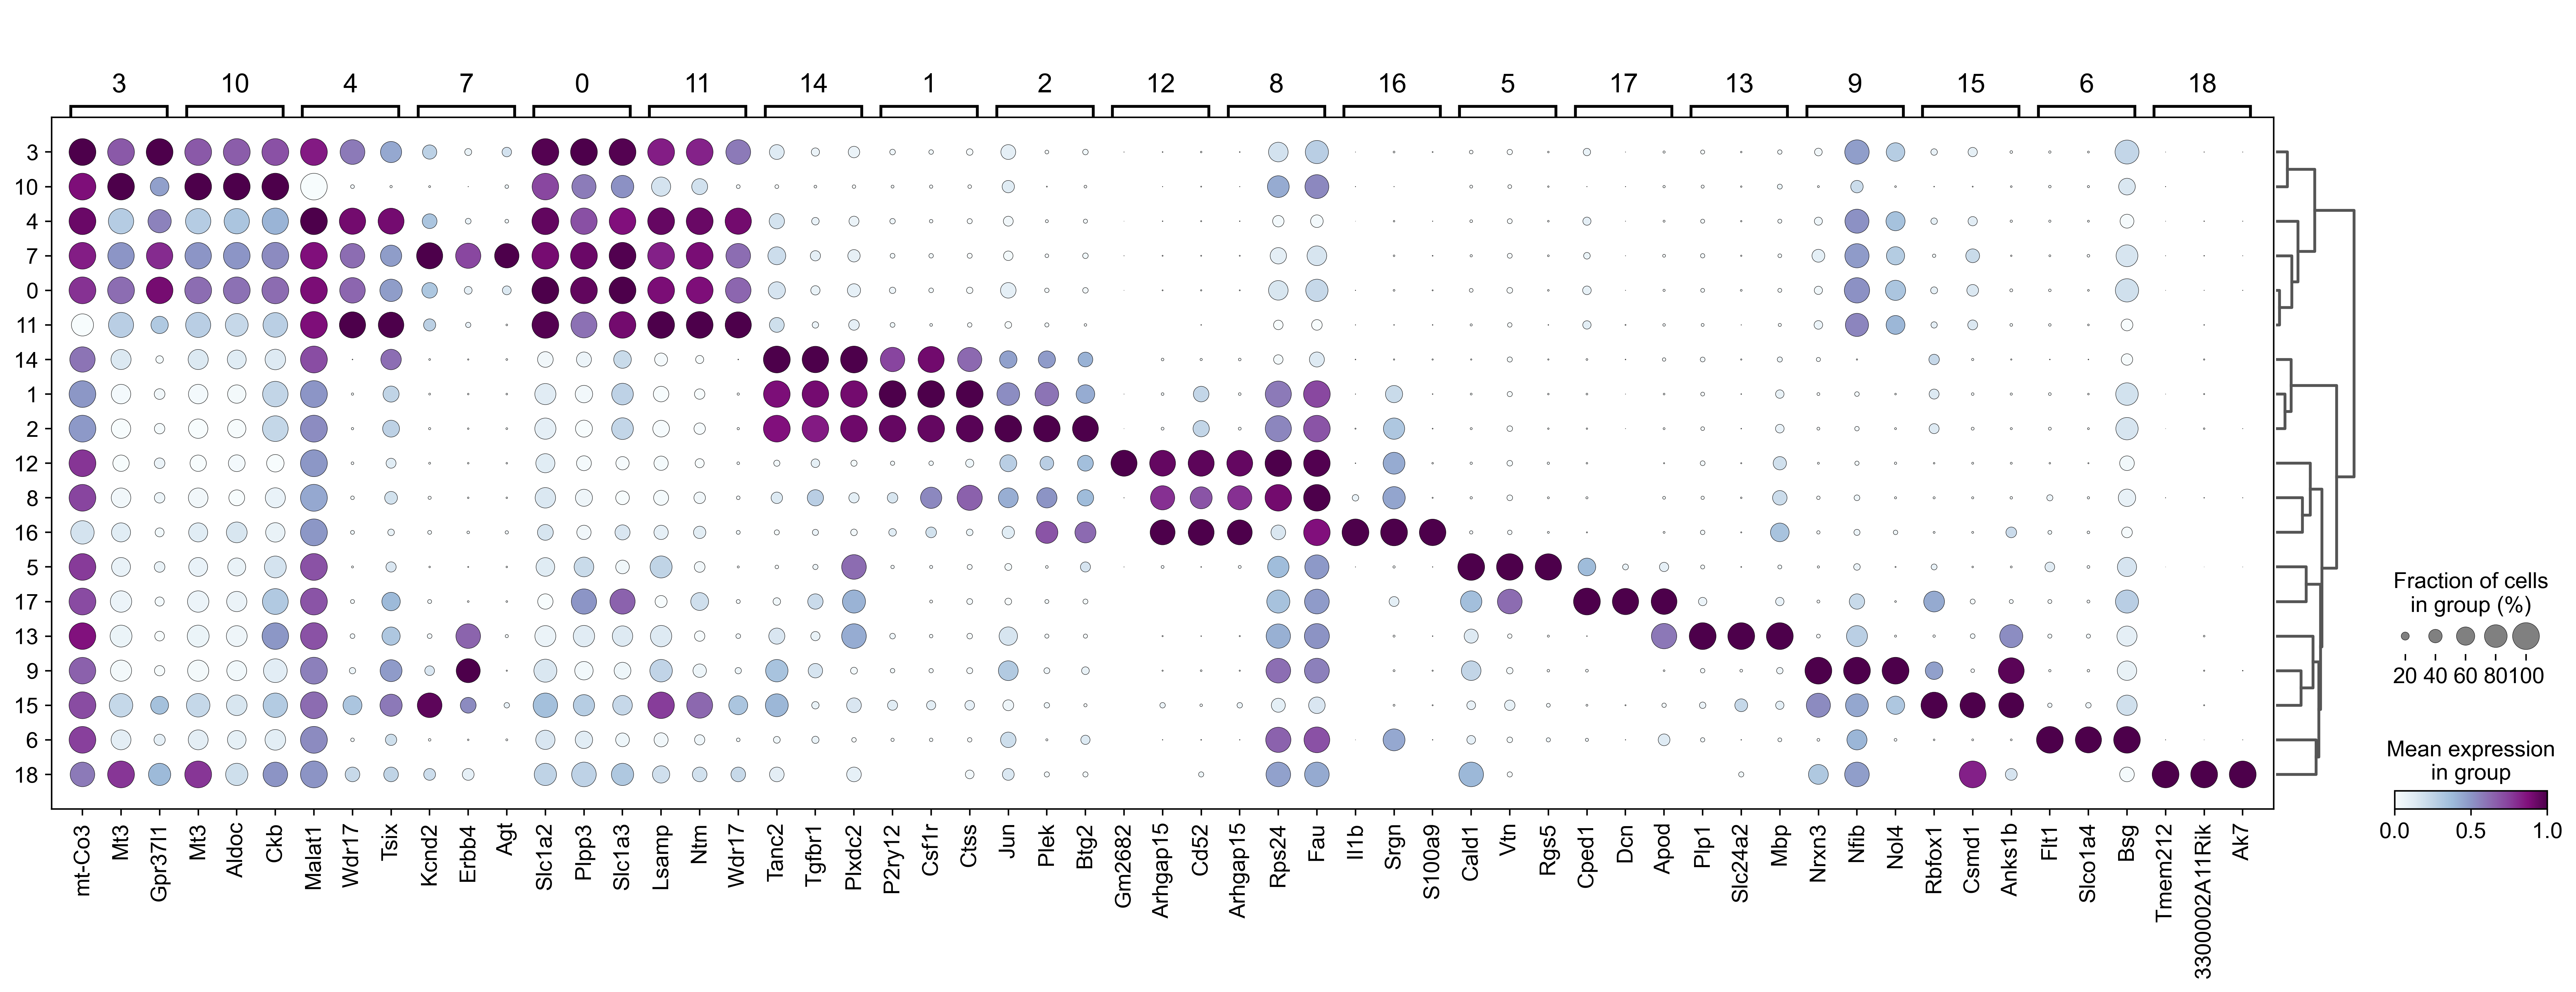

In [19]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby = "leiden_res_0.50", standard_scale="var", n_genes=3, cmap = "BuPu",
    save = "_deg_as_markers"
)

# Cell type annotation

In [20]:
marker_genes_tg_dict = {
    "Tg": ["cre"],
    "Astro": ["Aldh1l1"],
    "Exc": ["Slc17a7"],
    "Inh": ["Gad1"],
    "Micro": ["Aif1"],
    "Immune": ["Arhgap15"],
    "OL": ["Mbp"],
    "Endo": ["Flt1"],
    "Peri": ["Rgs5"],
    "VLMC": ["Apod"],
    "Ependymal": ["Tmem212"]
}
marker_genes_dict = marker_genes_tg_dict.copy()
marker_genes_dict.pop("Tg")

['cre']

categories: 0, 1, 2, etc.
var_group_labels: Tg, Astro, Exc, etc.


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


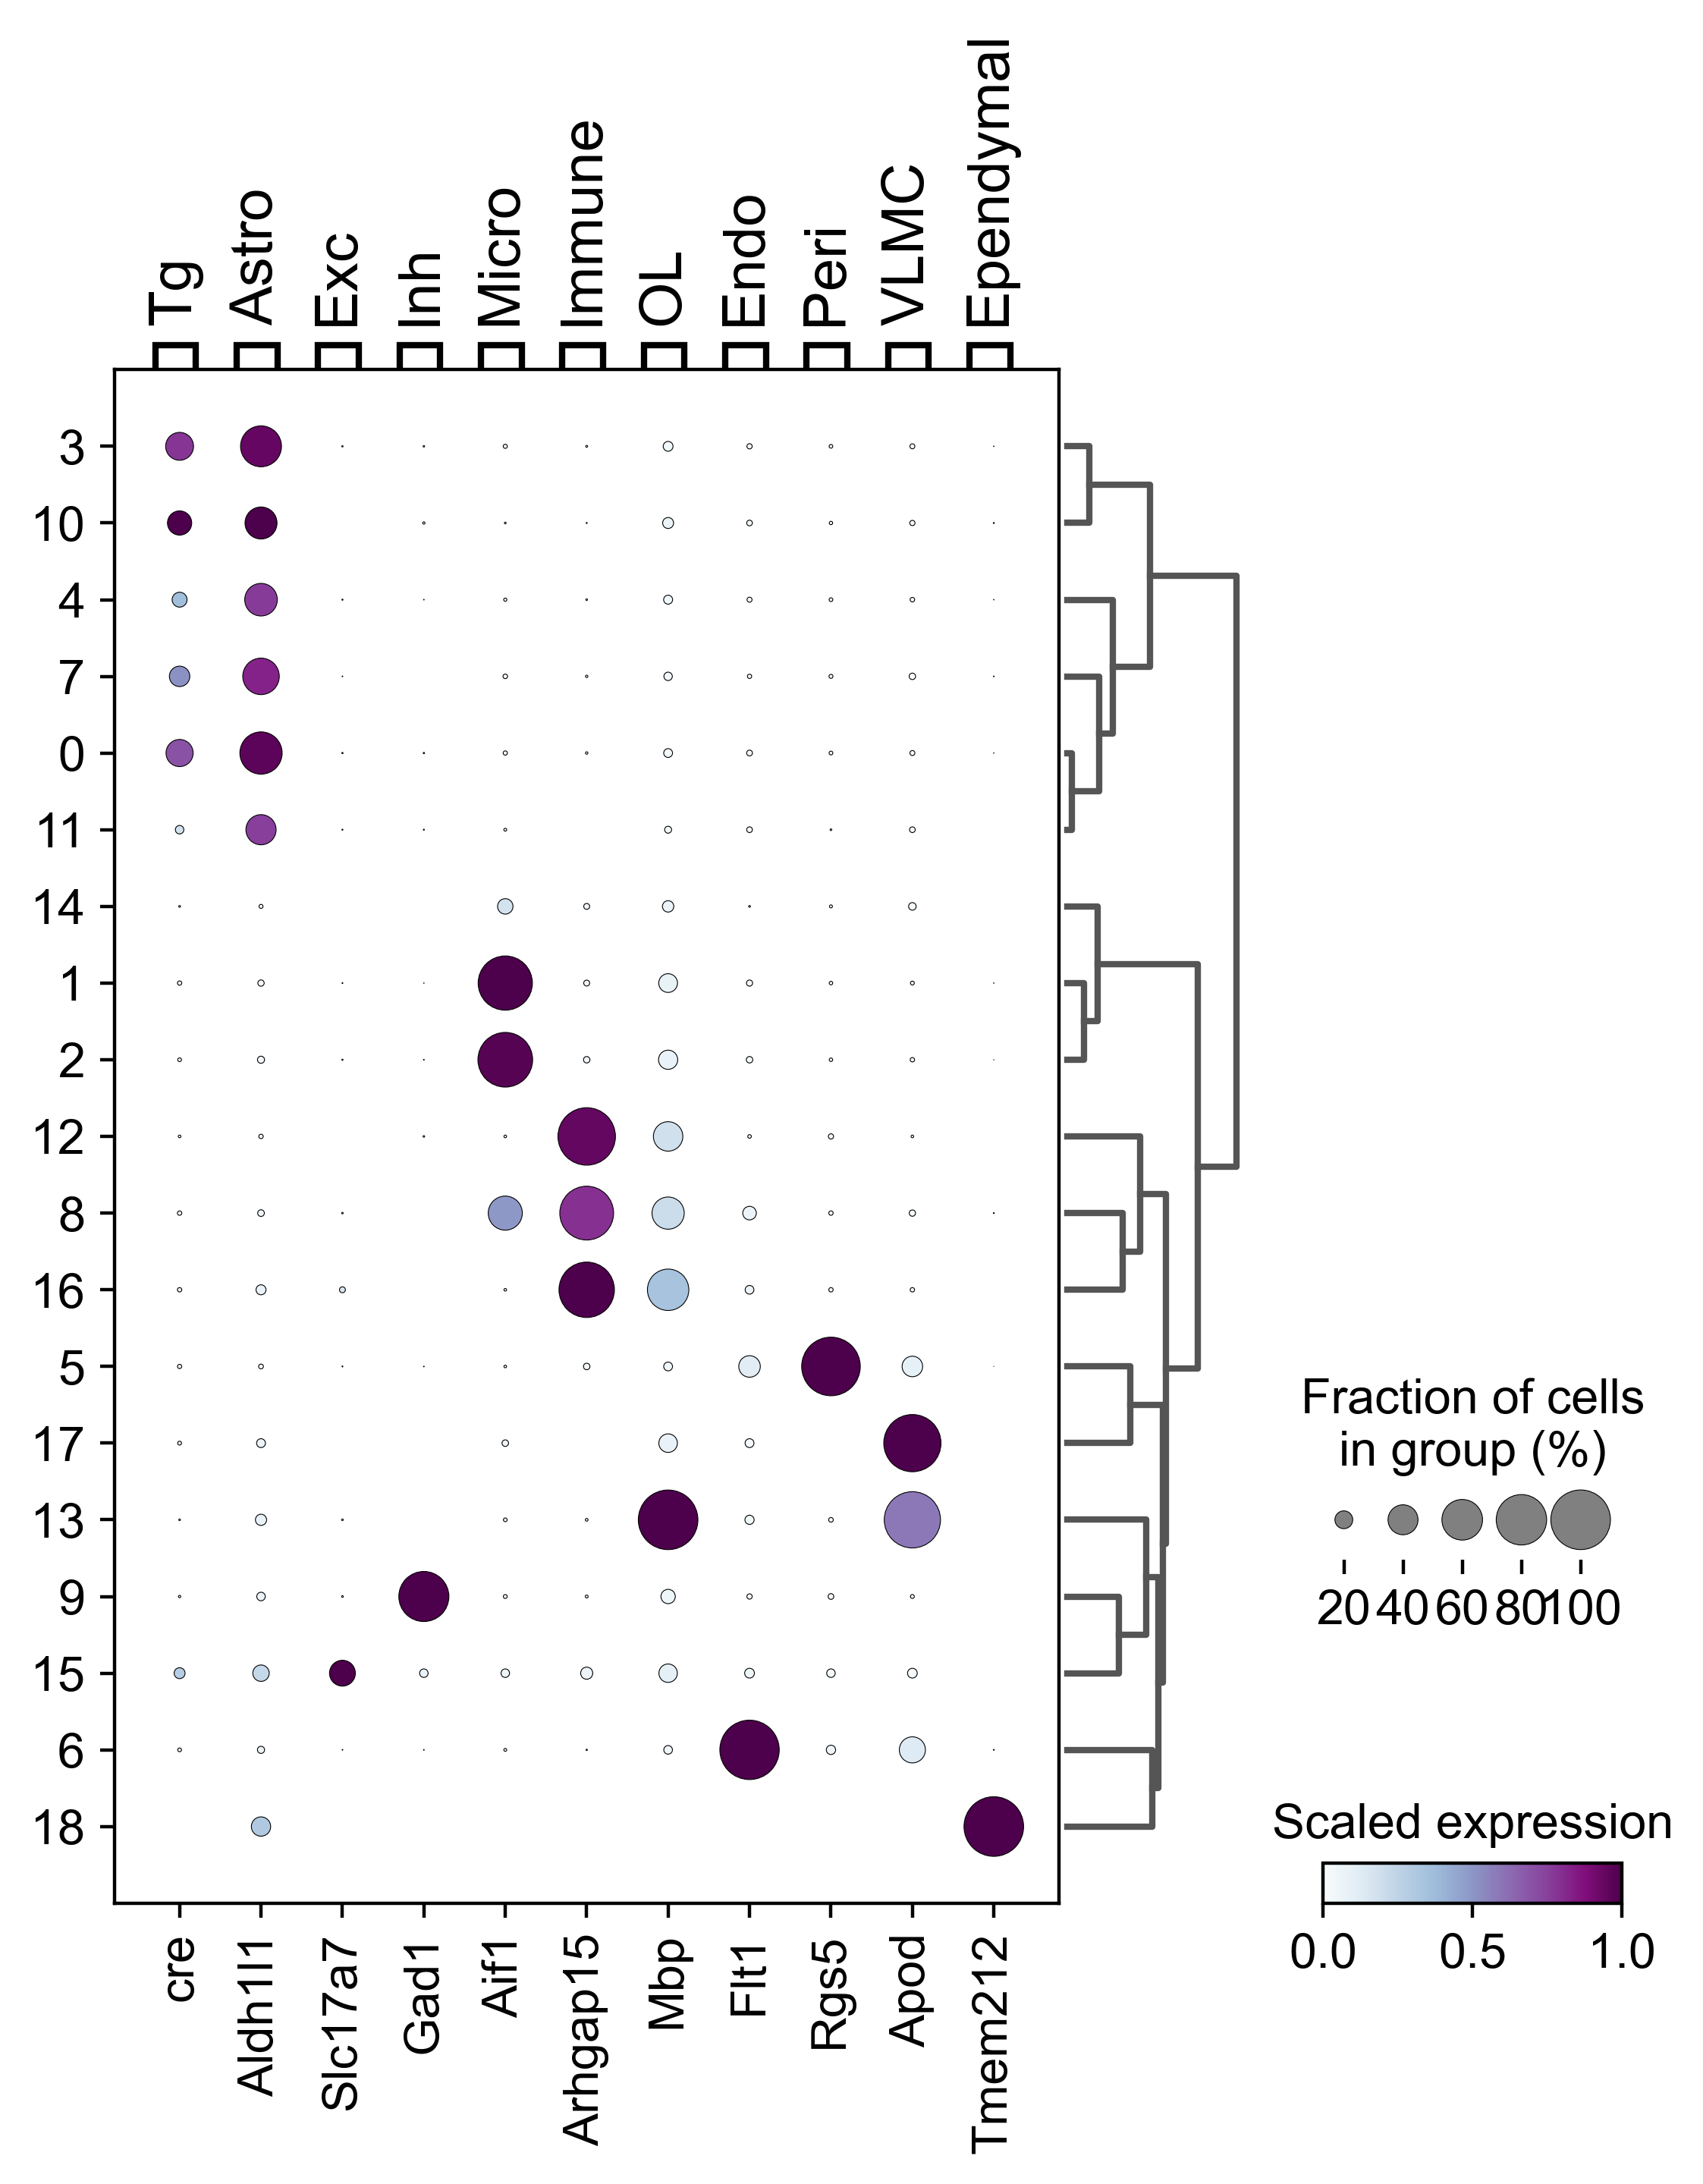

In [21]:
rcParams['patch.edgecolor'] = 'black'
sc.pl.dotplot(
    adata,
    marker_genes_tg_dict,
    groupby = "leiden_res_0.50",
    dendrogram = True,
    cmap = "BuPu",
    standard_scale = "var",
    colorbar_title = "Scaled expression",
    save = "cluster_marker"
)

In [22]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
    '0': 'Astro',
    '1': 'Micro',
    '2': 'Micro',
    '3': 'Astro',
    '4': 'Astro',
    '5': 'Peri',
    '6': 'Endo',
    '7': 'Astro',
    '8': 'Immune',
    '9': 'Inh',
    '10': 'Astro',
    '11': 'Astro',
    '12': 'Immune',
    '13': 'OL',
    '14': 'Micro',
    '15': 'Exc',
    '16': 'Immune',
    '17': 'VLMC',
    '18': 'Ependymal'
}

In [23]:
# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell type'] = adata.obs['leiden_res_0.50'].map(cluster2annotation).astype('category')

In [24]:
set(cluster2annotation.values())

{'Astro',
 'Endo',
 'Ependymal',
 'Exc',
 'Immune',
 'Inh',
 'Micro',
 'OL',
 'Peri',
 'VLMC'}

In [25]:
tab10 = sns.color_palette("tab10")
tab10

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [26]:
celltype_palette = {
    "Astro": "#1f78b4",
    "Exc": "#33a02c",
    "Inh": "#ff7f00",
    "Micro": "#6a3d9a",
    "Immune": "#cab2d6",
    "OL": "#a6cee3",
    "Endo": "#b2df8a",
    "Peri": "#fb9a99",
    "VLMC": "#e31a1c",
    "Ependymal": "#fdbf6f"
}

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


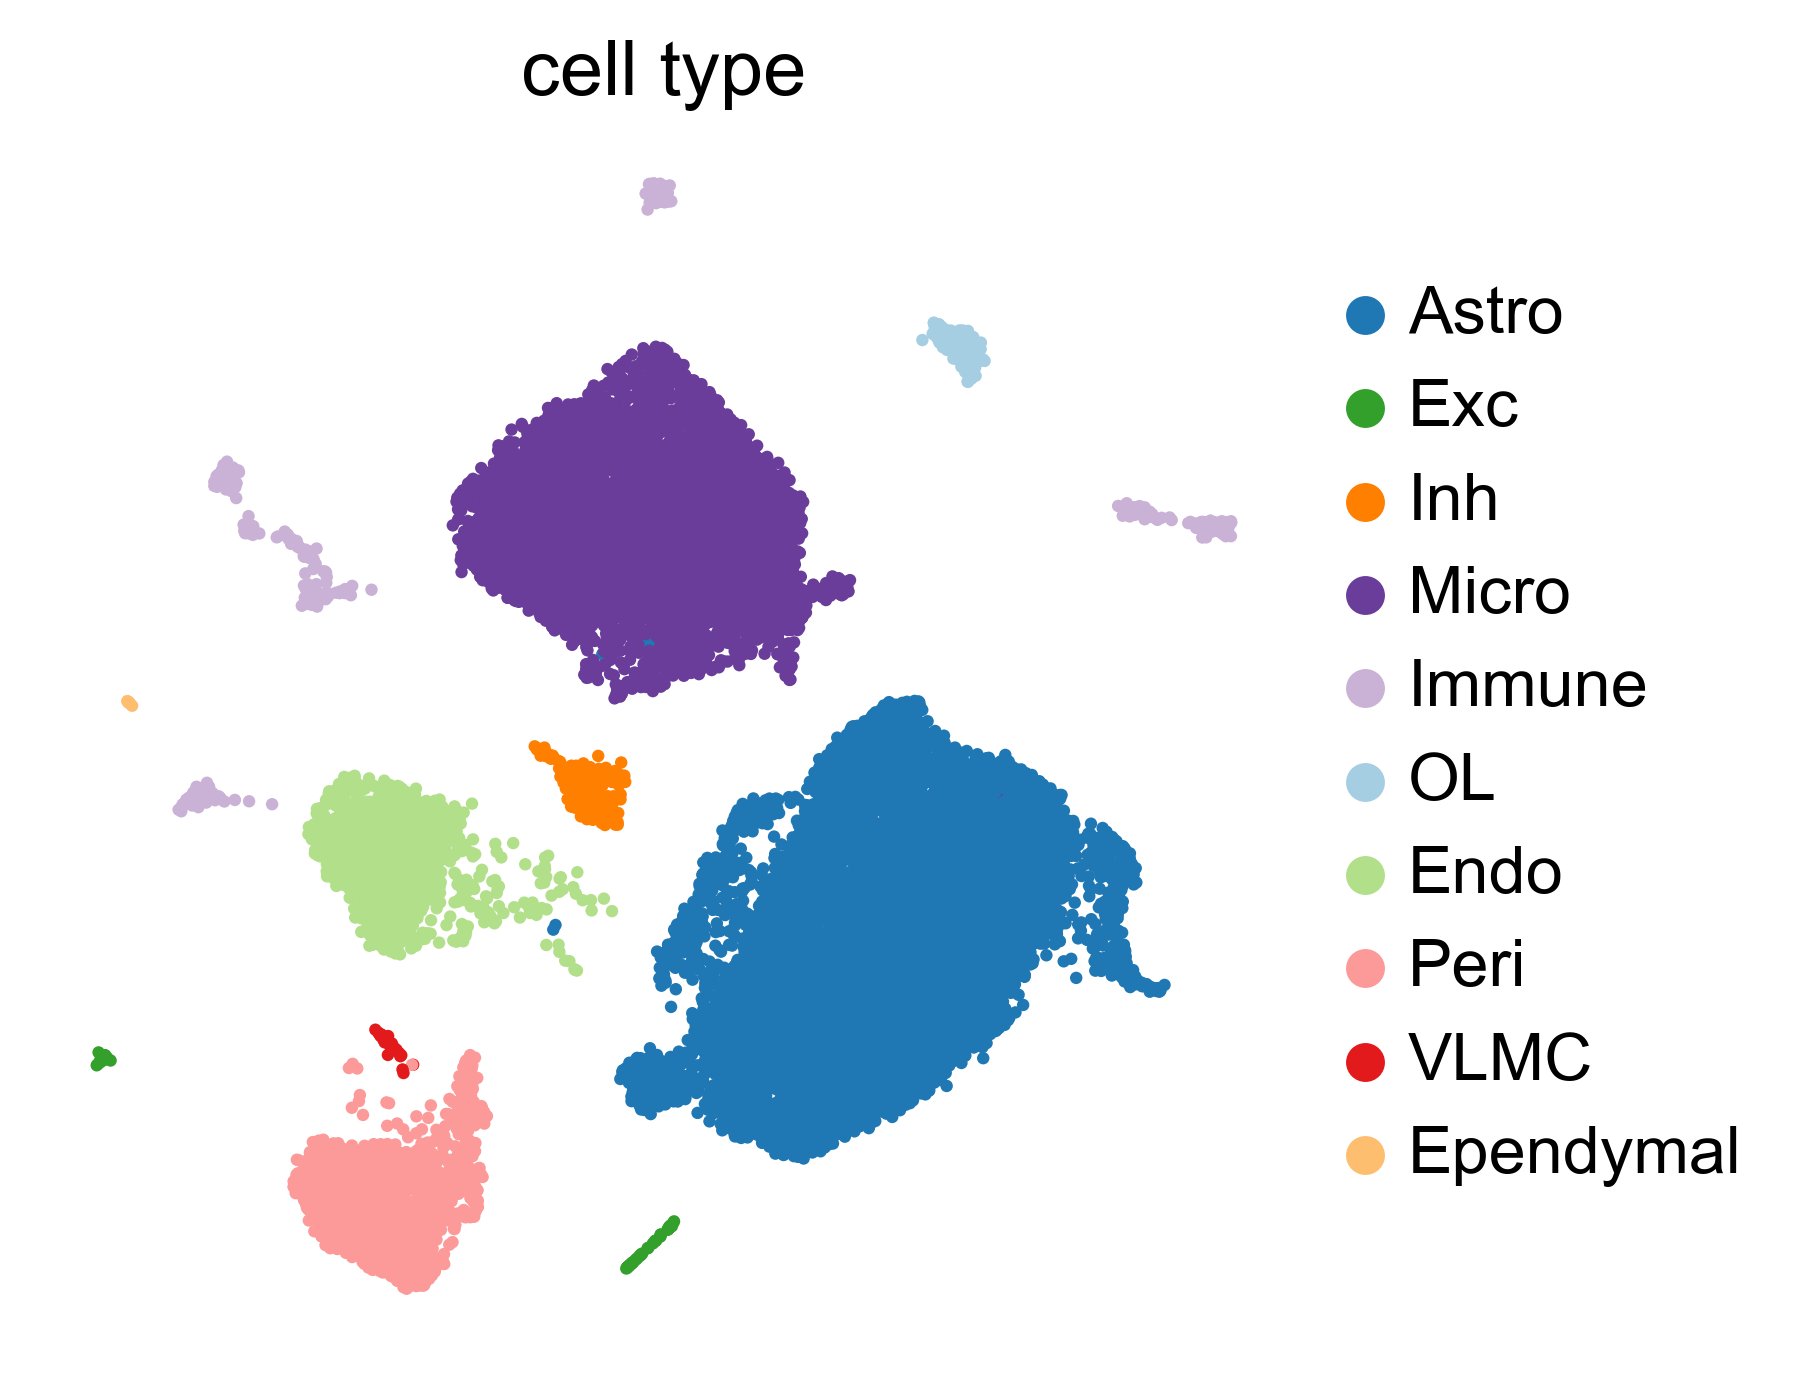

In [27]:
desired_order = celltype_palette.keys()
adata.obs['cell type'] = adata.obs['cell type'].cat.reorder_categories(desired_order, ordered=True)
sc.pl.umap(
    adata[random_indices, :],
    color = 'cell type',
    palette = celltype_palette,
    frameon = False,
    legend_fontsize = 12,
    legend_fontoutline = 3,
    size = 20,
    save = "_celltype.png"
)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell type']`


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


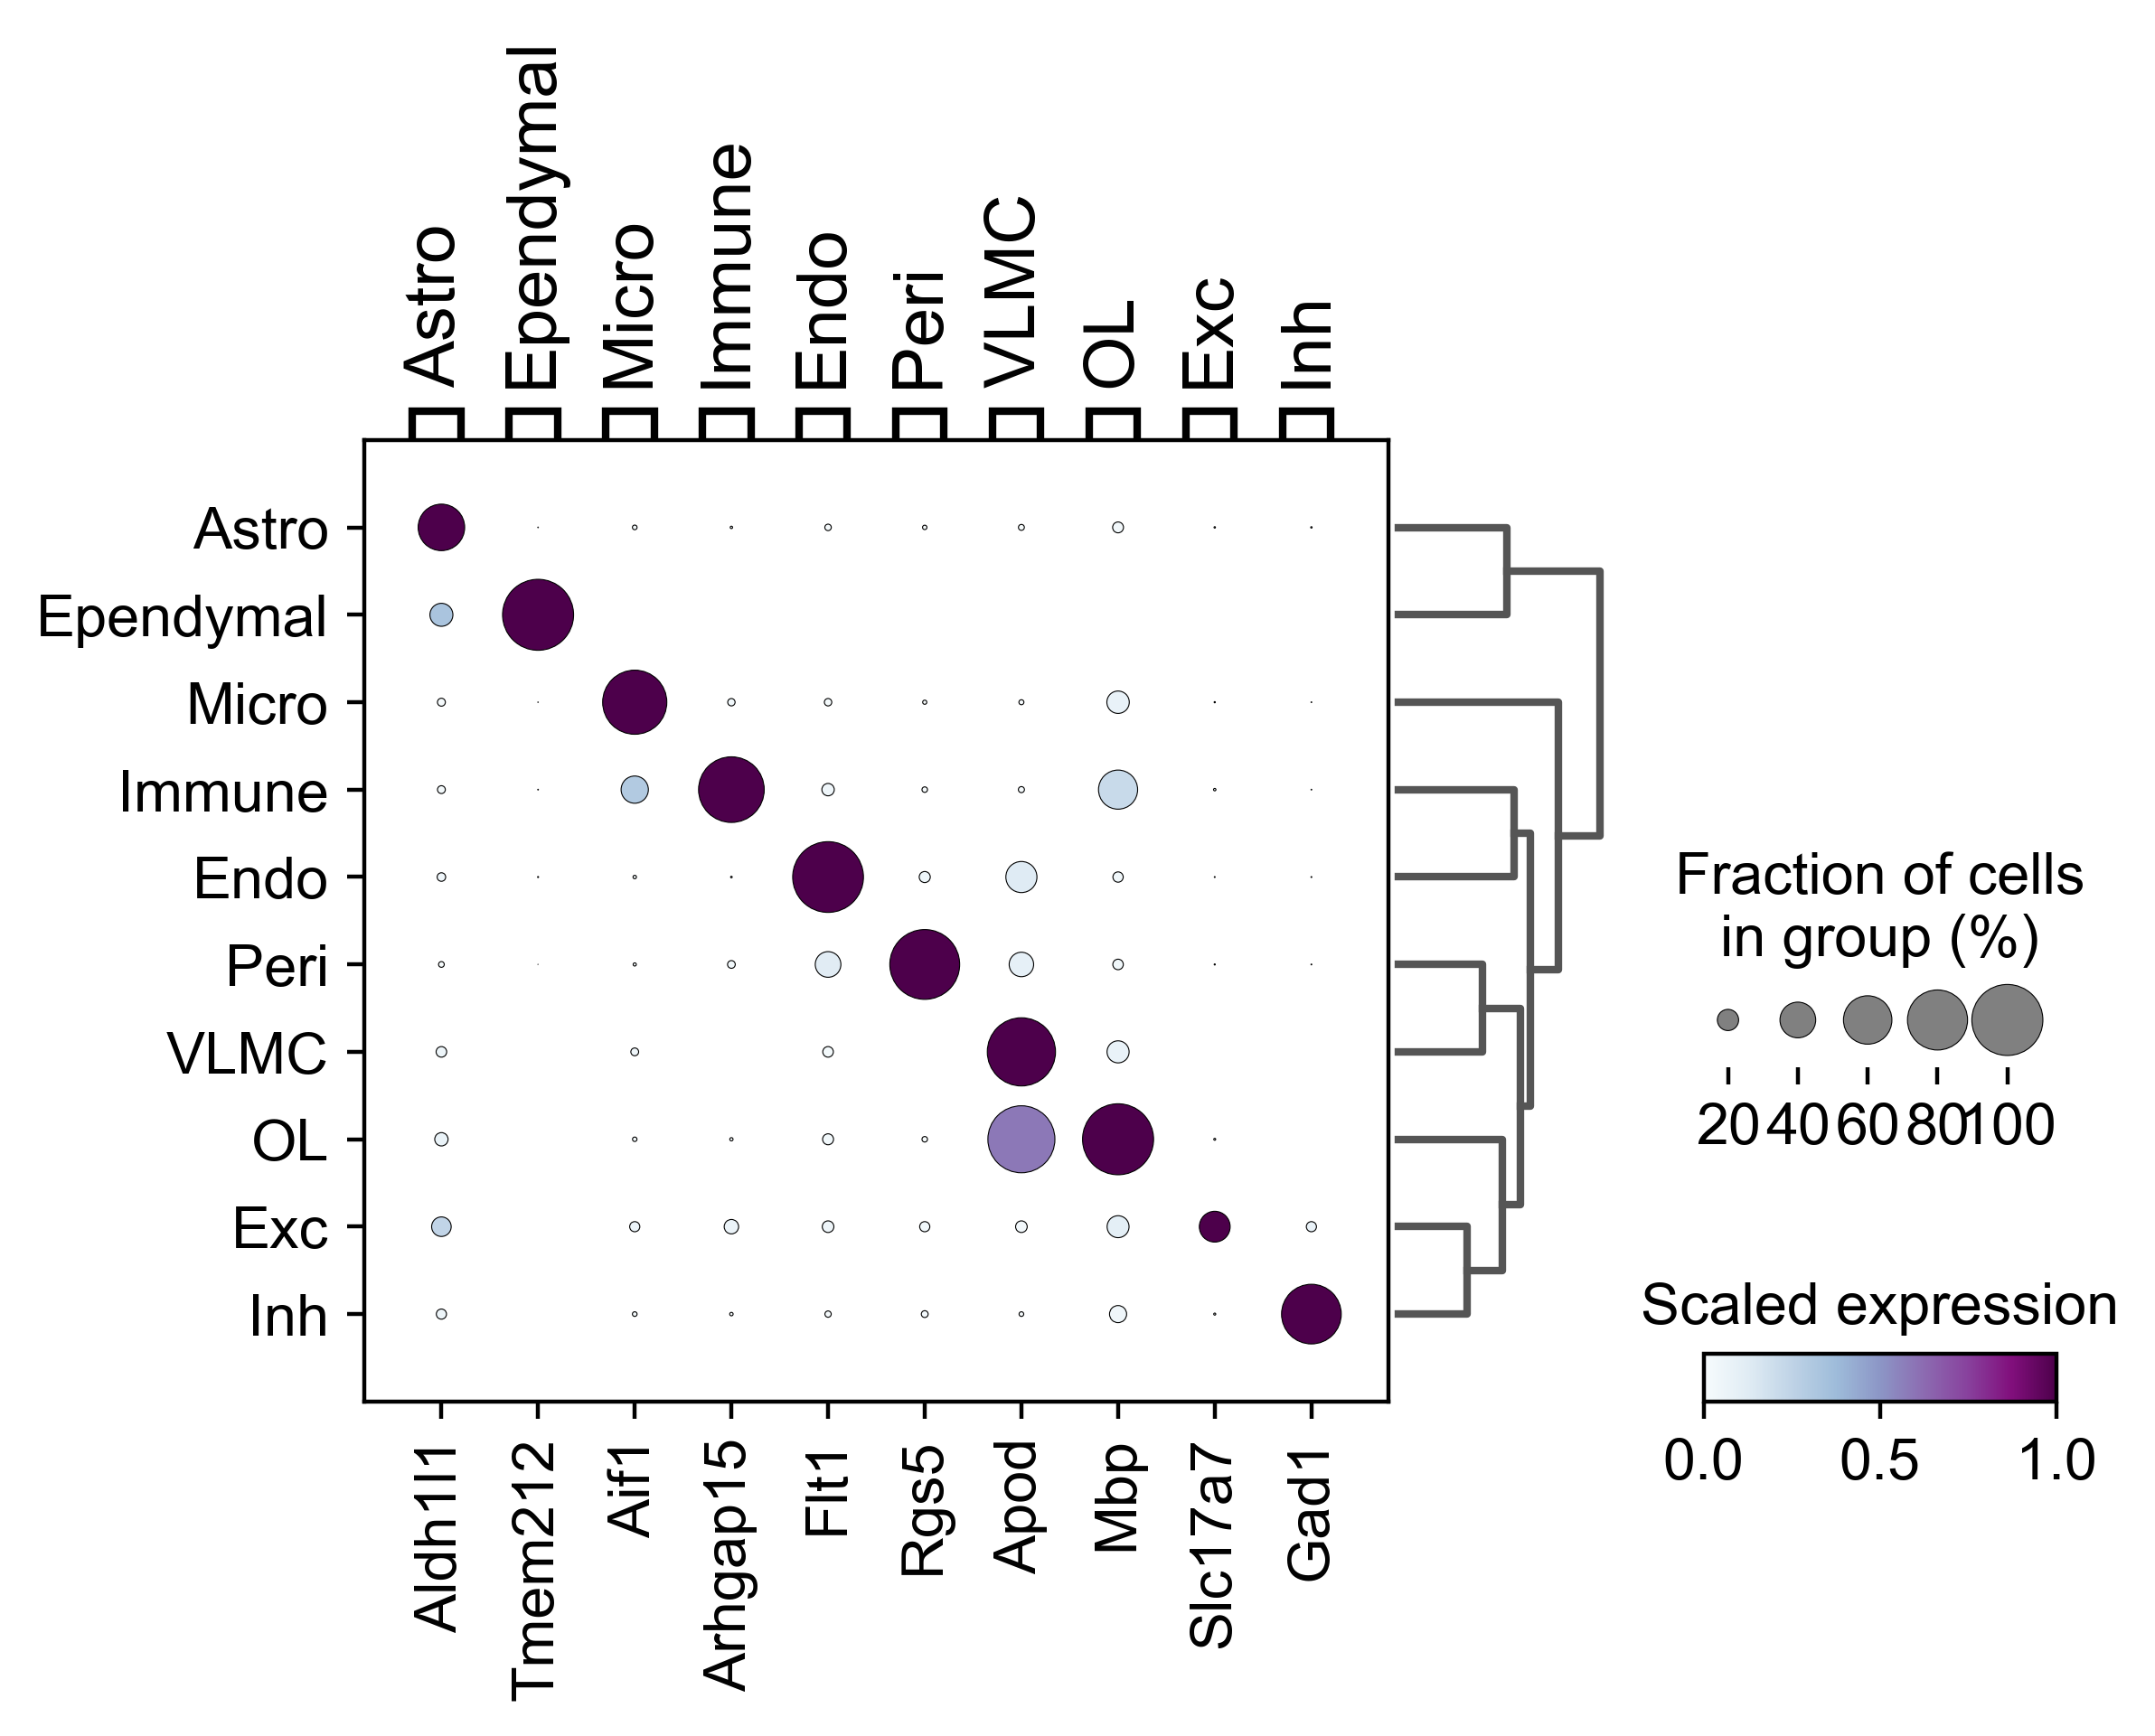

In [28]:
sc.pl.dotplot(
    adata,
    marker_genes_dict,
    groupby = "cell type",
    dendrogram = True,
    cmap = "BuPu",
    standard_scale = "var",
    colorbar_title = "Scaled expression",
    save = "cell_type_marker"
)

# WT vs. KO

## Cell type

In [31]:
# Find the index or name of the 'Cre' gene in .var
cre_index = adata.raw.var_names.get_loc("cre")
# Extract the expression values of 'Cre' gene for all cells
cre_expression = adata.raw.X[:, cre_index].toarray() if hasattr(adata.raw.X, "toarray") else adata.raw.X[:, cre_index]
# Create a binary column based on the threshold
cre_binary = ["Cre+" if x[0] else "Cre-" for x in (cre_expression > 0)]
# Add the binary column to .obs
adata.obs["Cre_binary"] = cre_binary

In [32]:
adata.obs

n_genes  n_genes_by_counts  log1p_n_genes_by_counts  \
barcode                                                                    
AAACCCAAGCTCGTGC-WT     2239               2239                 7.714231   
AAACCCAAGGATTCCT-WT     1981               1981                 7.591862   
AAACCCACAAATCAAG-WT     2533               2533                 7.837554   
AAACCCACACTGCTTC-WT     3516               3516                 8.165364   
AAACCCAGTAACGGTG-WT     2665               2665                 7.888335   
...                      ...                ...                      ...   
TTTGTTGGTATCGCTA-KO     1227               1227                 7.113142   
TTTGTTGTCAAGTCTG-KO     1713               1713                 7.446585   
TTTGTTGTCACTGAAC-KO      987                987                 6.895683   
TTTGTTGTCTACACTT-KO     3213               3213                 8.075272   
TTTGTTGTCTTCACAT-KO     1115               1115                 7.017506   

                     total_counts  log1p_total_counts  \
barcode                                                 
AAACCCAAGCTCGTGC-WT        4671.0            8.449343   
AAACCCAAGGATTCCT-WT        3860.0            8.258681   
AAACCCACAAATCAAG-WT        5723.0            8.652423   
AAACCCACACTGCTTC-WT        8796.0            9.082166   
AAACCCAGTAACGGTG-WT        5412.0            8.596559   
...                           ...                 ...   
TTTGTTGGTATCGCTA-KO        1892.0            7.545918   
TTTGTTGTCAAGTCTG-KO        3465.0            8.150756   
TTTGTTGTCACTGAAC-KO        1878.0            7.538495   
TTTGTTGTCTACACTT-KO        8459.0            9.043104   
TTTGTTGTCTTCACAT-KO        1947.0            7.574558   

                     pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
barcode                                                                        
AAACCCAAGCTCGTGC-WT                   28.195247                    34.789124   
AAACCCAAGGATTCCT-WT                   23.367876                    30.336788   
AAACCCACAAATCAAG-WT                   25.790669                    32.395597   
AAACCCACACTGCTTC-WT                   27.535243                    33.651660   
AAACCCAGTAACGGTG-WT                   17.239468                    23.872875   
...                                         ...                          ...   
TTTGTTGGTATCGCTA-KO                   26.215645                    32.980973   
TTTGTTGTCAAGTCTG-KO                   27.503608                    35.526696   
TTTGTTGTCACTGAAC-KO                   32.641108                    42.119276   
TTTGTTGTCTACACTT-KO                   30.689207                    37.581274   
TTTGTTGTCTTCACAT-KO                   28.197227                    36.774525   

                     pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
barcode                                                                         
AAACCCAAGCTCGTGC-WT                    43.245558                    58.274459   
AAACCCAAGGATTCCT-WT                    39.300518                    57.383420   
AAACCCACAAATCAAG-WT                    41.149747                    56.980605   
AAACCCACACTGCTTC-WT                    40.961801                    54.149613   
AAACCCAGTAACGGTG-WT                    32.945307                    50.757576   
...                                          ...                          ...   
TTTGTTGGTATCGCTA-KO                    43.551797                    61.575053   
TTTGTTGTCAAGTCTG-KO                    45.858586                    64.040404   
TTTGTTGTCACTGAAC-KO                    54.419595                    74.068158   
TTTGTTGTCTACACTT-KO                    45.135359                    58.127438   
TTTGTTGTCTTCACAT-KO                    48.073960                    68.412943   

                     total_counts_mt  log1p_total_counts_mt  pct_counts_mt  \
barcode                                                                      
AAACCCAAGCTCGTGC-WT            208.0   

In [33]:
adata.obs['celltype_group'] = adata.obs['cell type'].astype(str) + " (" + adata.obs['batch_short'].astype(str) + ")"
obs_df = adata.obs
batch_celltype_size_df = obs_df.groupby(["batch", "cell type"], as_index = False).size()
# Calculate the total size per batch
batch_totals = batch_celltype_size_df.groupby('batch')['size'].transform('sum')
# Calculate the proportion of each cell type within each batch
batch_celltype_size_df['proportion'] = (batch_celltype_size_df['size'] / batch_totals)*100
batch_celltype_size_df

batch  cell type  size  proportion
0     Control      Astro  5486   50.557552
1     Control        Exc    28    0.258041
2     Control        Inh    99    0.912358
3     Control      Micro  3642   33.563727
4     Control     Immune   324    2.985900
5     Control         OL    32    0.294904
6     Control       Endo   524    4.829048
7     Control       Peri   704    6.487881
8     Control       VLMC     9    0.082942
9     Control  Ependymal     3    0.027647
10  Ptbp1 cKO      Astro  4181   48.650221
11  Ptbp1 cKO        Exc    39    0.453805
12  Ptbp1 cKO        Inh   128    1.489411
13  Ptbp1 cKO      Micro  2285   26.588317
14  Ptbp1 cKO     Immune   128    1.489411
15  Ptbp1 cKO         OL    89    1.035606
16  Ptbp1 cKO       Endo   893   10.390970
17  Ptbp1 cKO       Peri   816    9.494997
18  Ptbp1 cKO       VLMC    29    0.337445
19  Ptbp1 cKO  Ependymal     6    0.069816

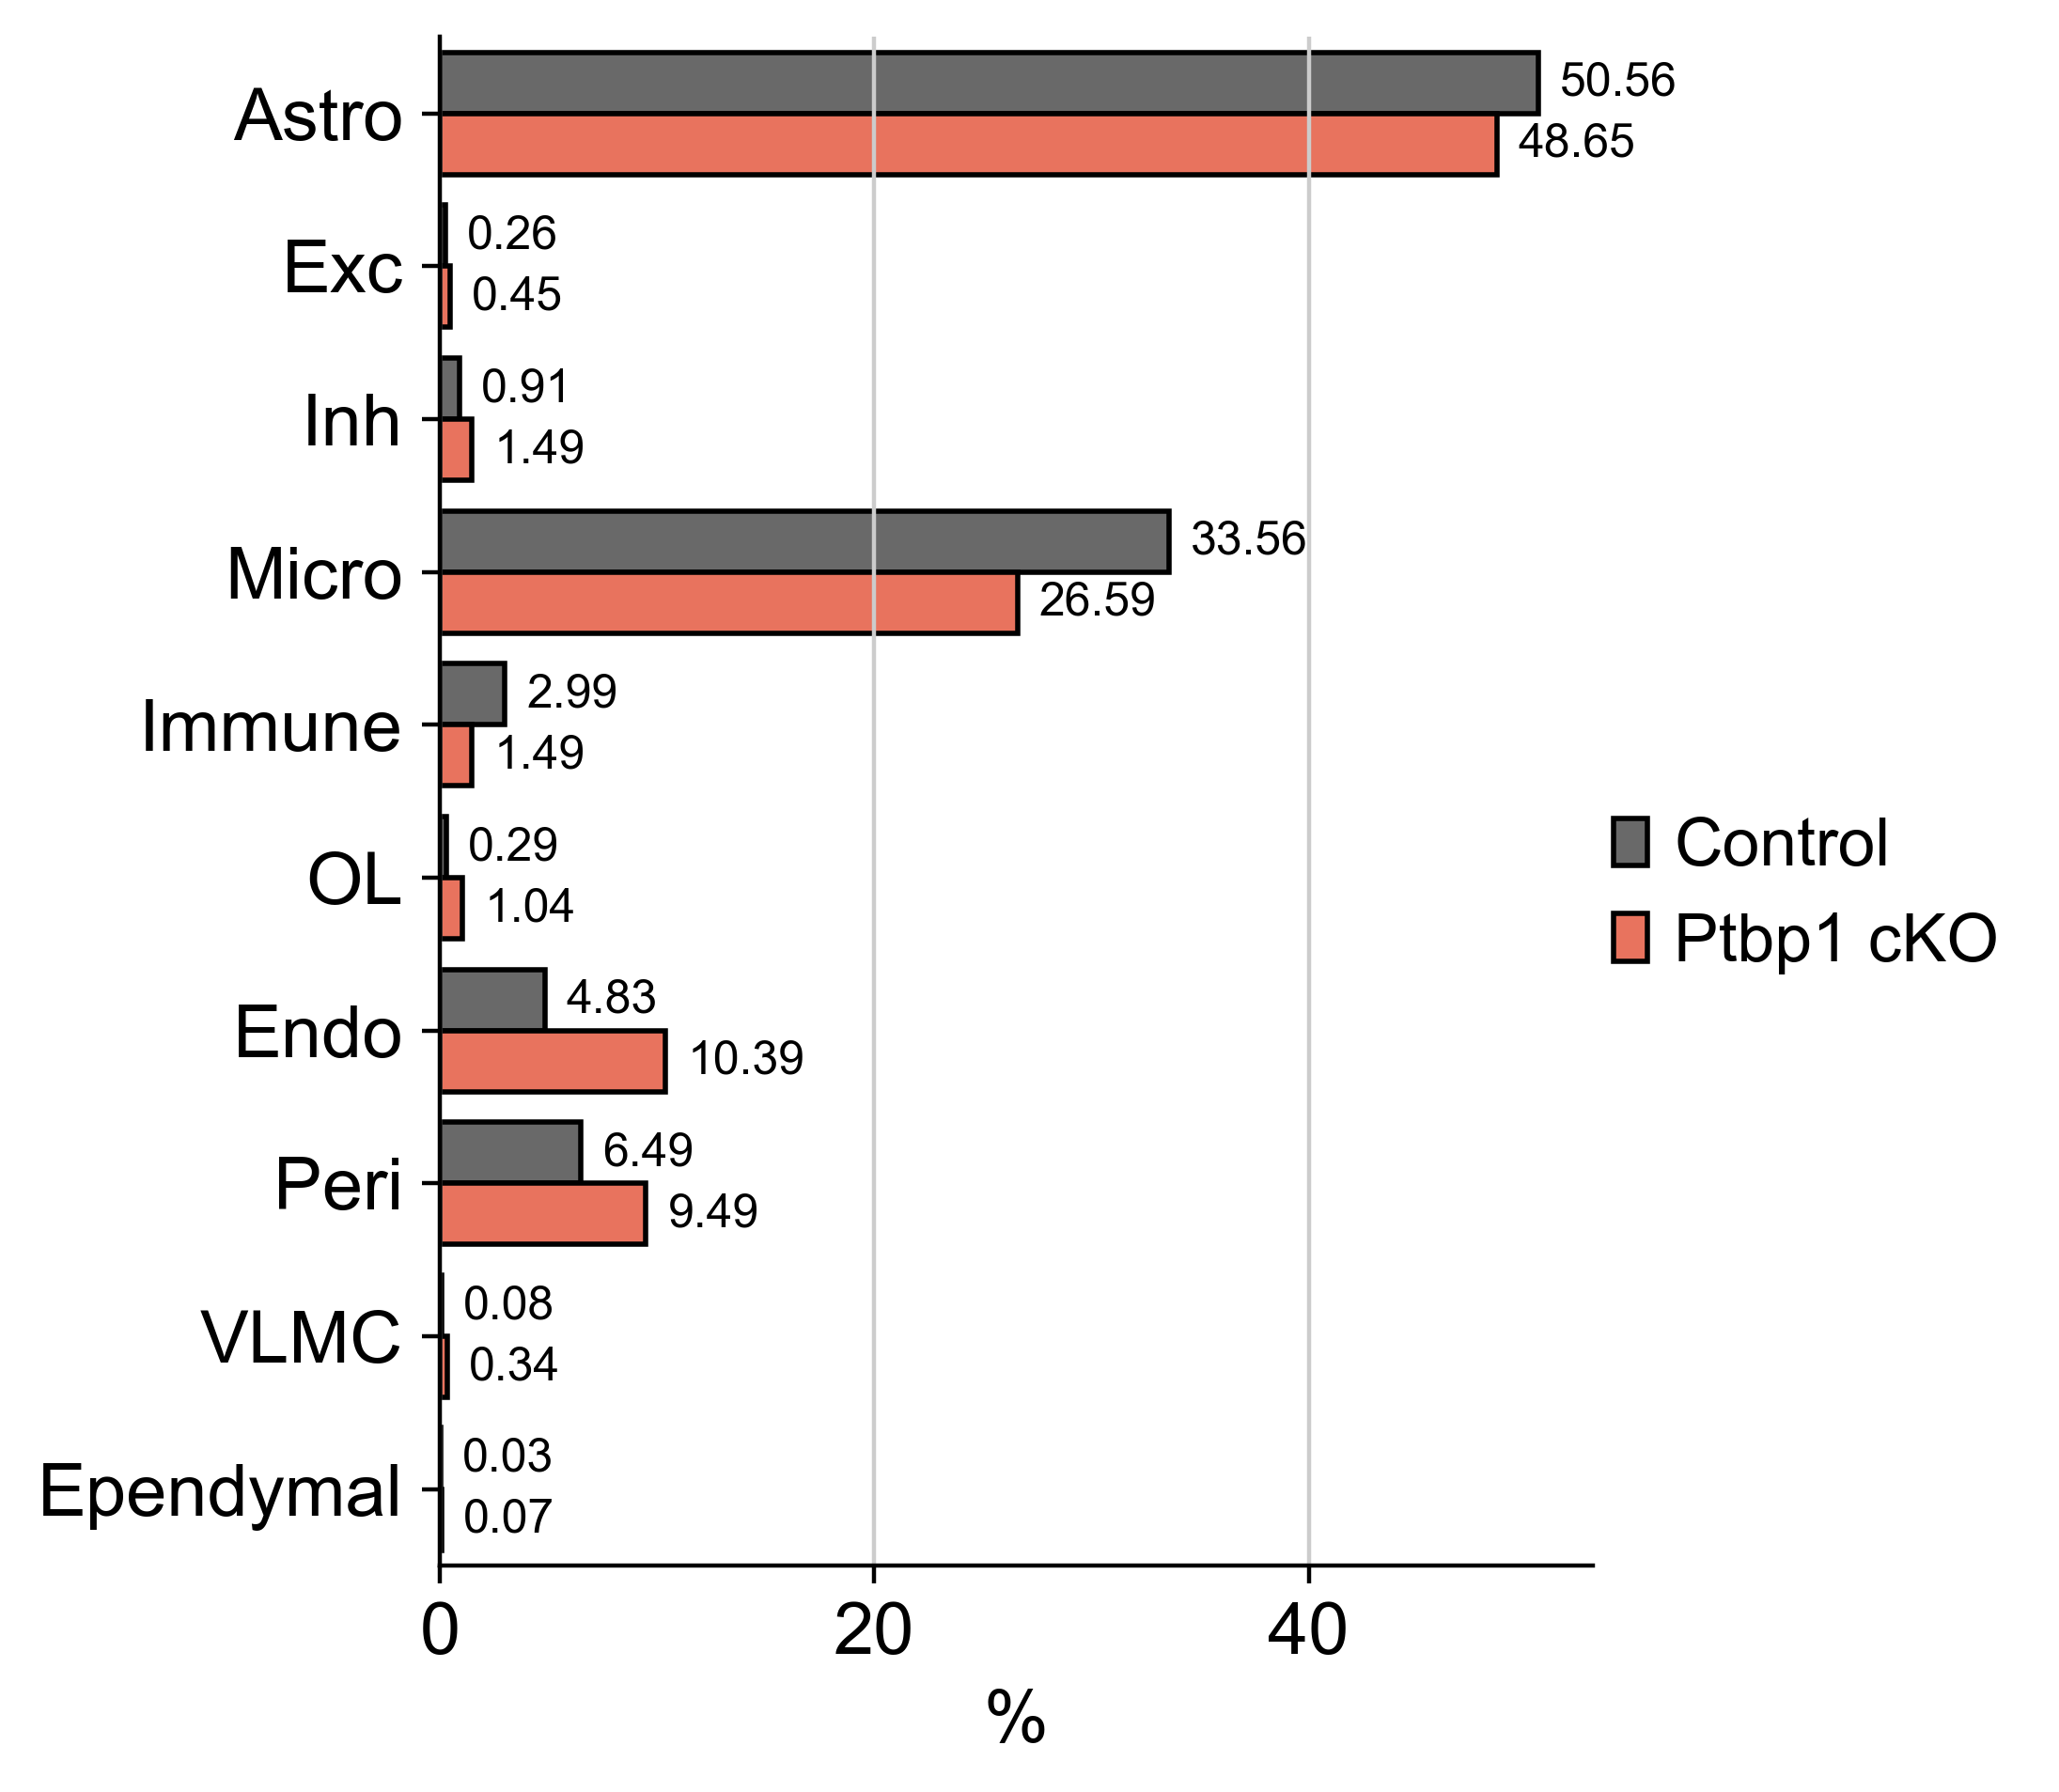

In [34]:
g = sns.catplot(
    data = batch_celltype_size_df,
    y = "cell type",
    order = celltype_palette.keys(),
    x = "proportion",
    hue = "batch",
    hue_order = ["Control", "Ptbp1 cKO"],
    palette = {"Control": "dimgrey", "Ptbp1 cKO": "tomato"},
    kind = "bar",
    linewidth = 1,
    edgecolor = "black"
)
g.set_axis_labels("%", "")
g._legend.set_title(None)

# Iterate over the axes and annotate each bar
for ax in g.axes.flat:
    for container in ax.containers:
        # Iterate through each bar
        for bar in container:
            # Get the value of the bar (x value since it's horizontal)
            width = bar.get_width()
            # Annotate the bar with the value
            ax.text(
                width + 1,  # x-coordinate
                bar.get_y() + bar.get_height() / 2,  # y-coordinate
                f'{width:.2f}',  # Label
                ha='left',  # Align the text to the left of the bar end
                va='center',  # Center the text vertically
                fontsize=9
            )
plt.savefig(workdir + "/scanpy/figures/celltype_size_WTvsKO.png", dpi = 1000, bbox_inches = "tight")

In [35]:
marker_genes_tg_dict

{'Tg': ['cre'],
 'Astro': ['Aldh1l1'],
 'Exc': ['Slc17a7'],
 'Inh': ['Gad1'],
 'Micro': ['Aif1'],
 'Immune': ['Arhgap15'],
 'OL': ['Mbp'],
 'Endo': ['Flt1'],
 'Peri': ['Rgs5'],
 'VLMC': ['Apod'],
 'Ependymal': ['Tmem212']}

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


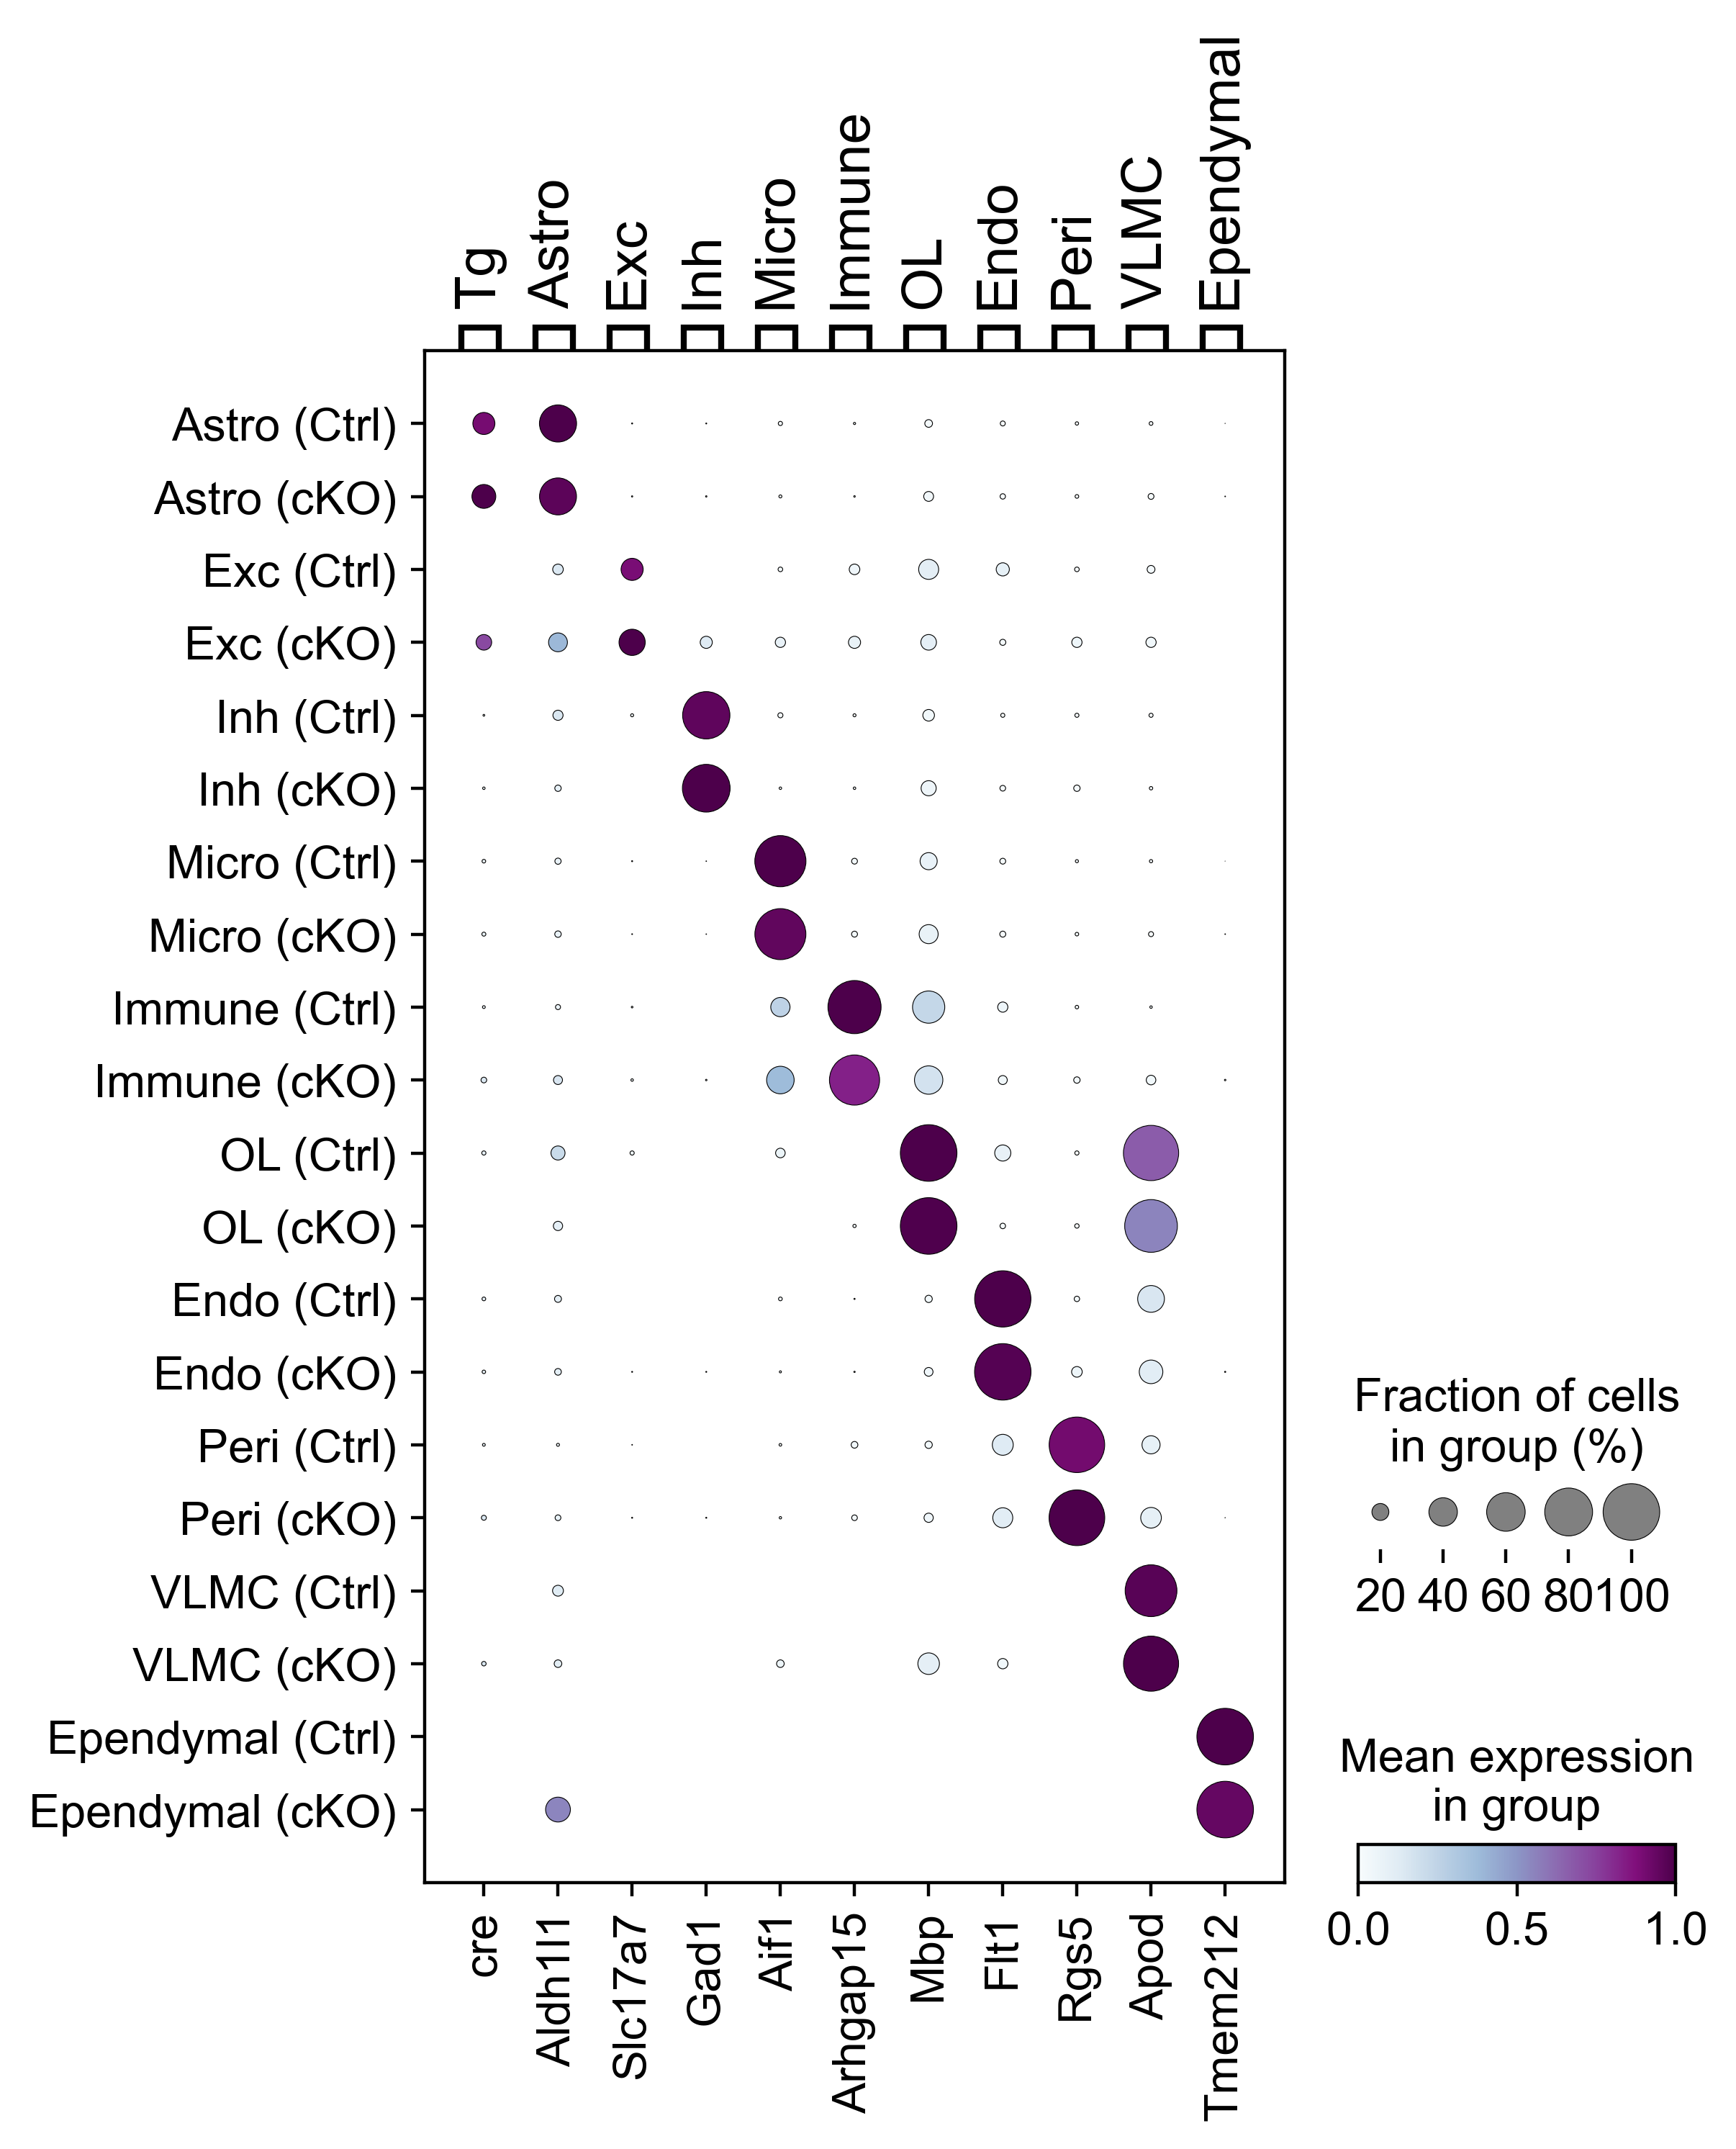

In [37]:
dp = sc.pl.dotplot(
    adata,
    marker_genes_tg_dict,
    groupby = "celltype_group",
    categories_order = sum([[x + " (Ctrl)", x + " (cKO)"] for x in marker_genes_dict.keys()], []),
    dendrogram = False,
    cmap = "BuPu",
    standard_scale = "var",
    save = "celltype_marker_WTvsKO.png"
)

In [39]:
batch_celltype_size_cre_df = obs_df.groupby(["batch", "cell type", "Cre_binary"], as_index = False).size()
# Calculate the total size per batch and cre
batch_cre_totals = batch_celltype_size_cre_df.groupby(['batch', 'Cre_binary'])['size'].transform('sum')
# Calculate the proportion of each cell type within each batch
batch_celltype_size_cre_df['proportion'] = (batch_celltype_size_cre_df['size'] / batch_cre_totals)*100
batch_celltype_size_cre_df

batch  cell type Cre_binary  size  proportion
0     Control      Astro       Cre+  1561   92.312241
1     Control      Astro       Cre-  3925   42.849345
2     Control        Exc       Cre+     0    0.000000
3     Control        Exc       Cre-    28    0.305677
4     Control        Inh       Cre+     1    0.059137
5     Control        Inh       Cre-    98    1.069869
6     Control      Micro       Cre+    95    5.617978
7     Control      Micro       Cre-  3547   38.722707
8     Control     Immune       Cre+     6    0.354820
9     Control     Immune       Cre-   318    3.471616
10    Control         OL       Cre+     1    0.059137
11    Control         OL       Cre-    31    0.338428
12    Control       Endo       Cre+    14    0.827912
13    Control       Endo       Cre-   510    5.567686
14    Control       Peri       Cre+    13    0.768776
15    Control       Peri       Cre-   691    7.543668
16    Control       VLMC       Cre+     0    0.000000
17    Control       VLMC       Cre-     9    0.098253
18    Control  Ependymal       Cre+     0    0.000000
19    Control  Ependymal       Cre-     3    0.032751
20  Ptbp1 cKO      Astro       Cre+  1323   90.616438
21  Ptbp1 cKO      Astro       Cre-  2858   40.061676
22  Ptbp1 cKO        Exc       Cre+     7    0.479452
23  Ptbp1 cKO        Exc       Cre-    32    0.448556
24  Ptbp1 cKO        Inh       Cre+     2    0.136986
25  Ptbp1 cKO        Inh       Cre-   126    1.766190
26  Ptbp1 cKO      Micro       Cre+    67    4.589041
27  Ptbp1 cKO      Micro       Cre-  2218   31.090552
28  Ptbp1 cKO     Immune       Cre+     6    0.410959
29  Ptbp1 cKO     Immune       Cre-   122    1.710121
30  Ptbp1 cKO         OL       Cre+     0    0.000000
31  Ptbp1 cKO         OL       Cre-    89    1.247547
32  Ptbp1 cKO       Endo       Cre+    22    1.506849
33  Ptbp1 cKO       Endo       Cre-   871   12.209139
34  Ptbp1 cKO       Peri       Cre+    32    2.191781
35  Ptbp1 cKO       Peri       Cre-   784   10.989627
36  Ptbp1 cKO       VLMC       Cre+     1    0.068493
37  Ptbp1 cKO       VLMC       Cre-    28    0.392487
38  Ptbp1 cKO  Ependymal       Cre+     0    0.000000
39  Ptbp1 cKO  Ependymal       Cre-     6    0.084104

In [40]:
batch_celltype_size_cre_df.groupby(["batch", "Cre_binary"])["size"].sum()

batch      Cre_binary
Control    Cre+          1691
           Cre-          9160
Ptbp1 cKO  Cre+          1460
           Cre-          7134
Name: size, dtype: int64

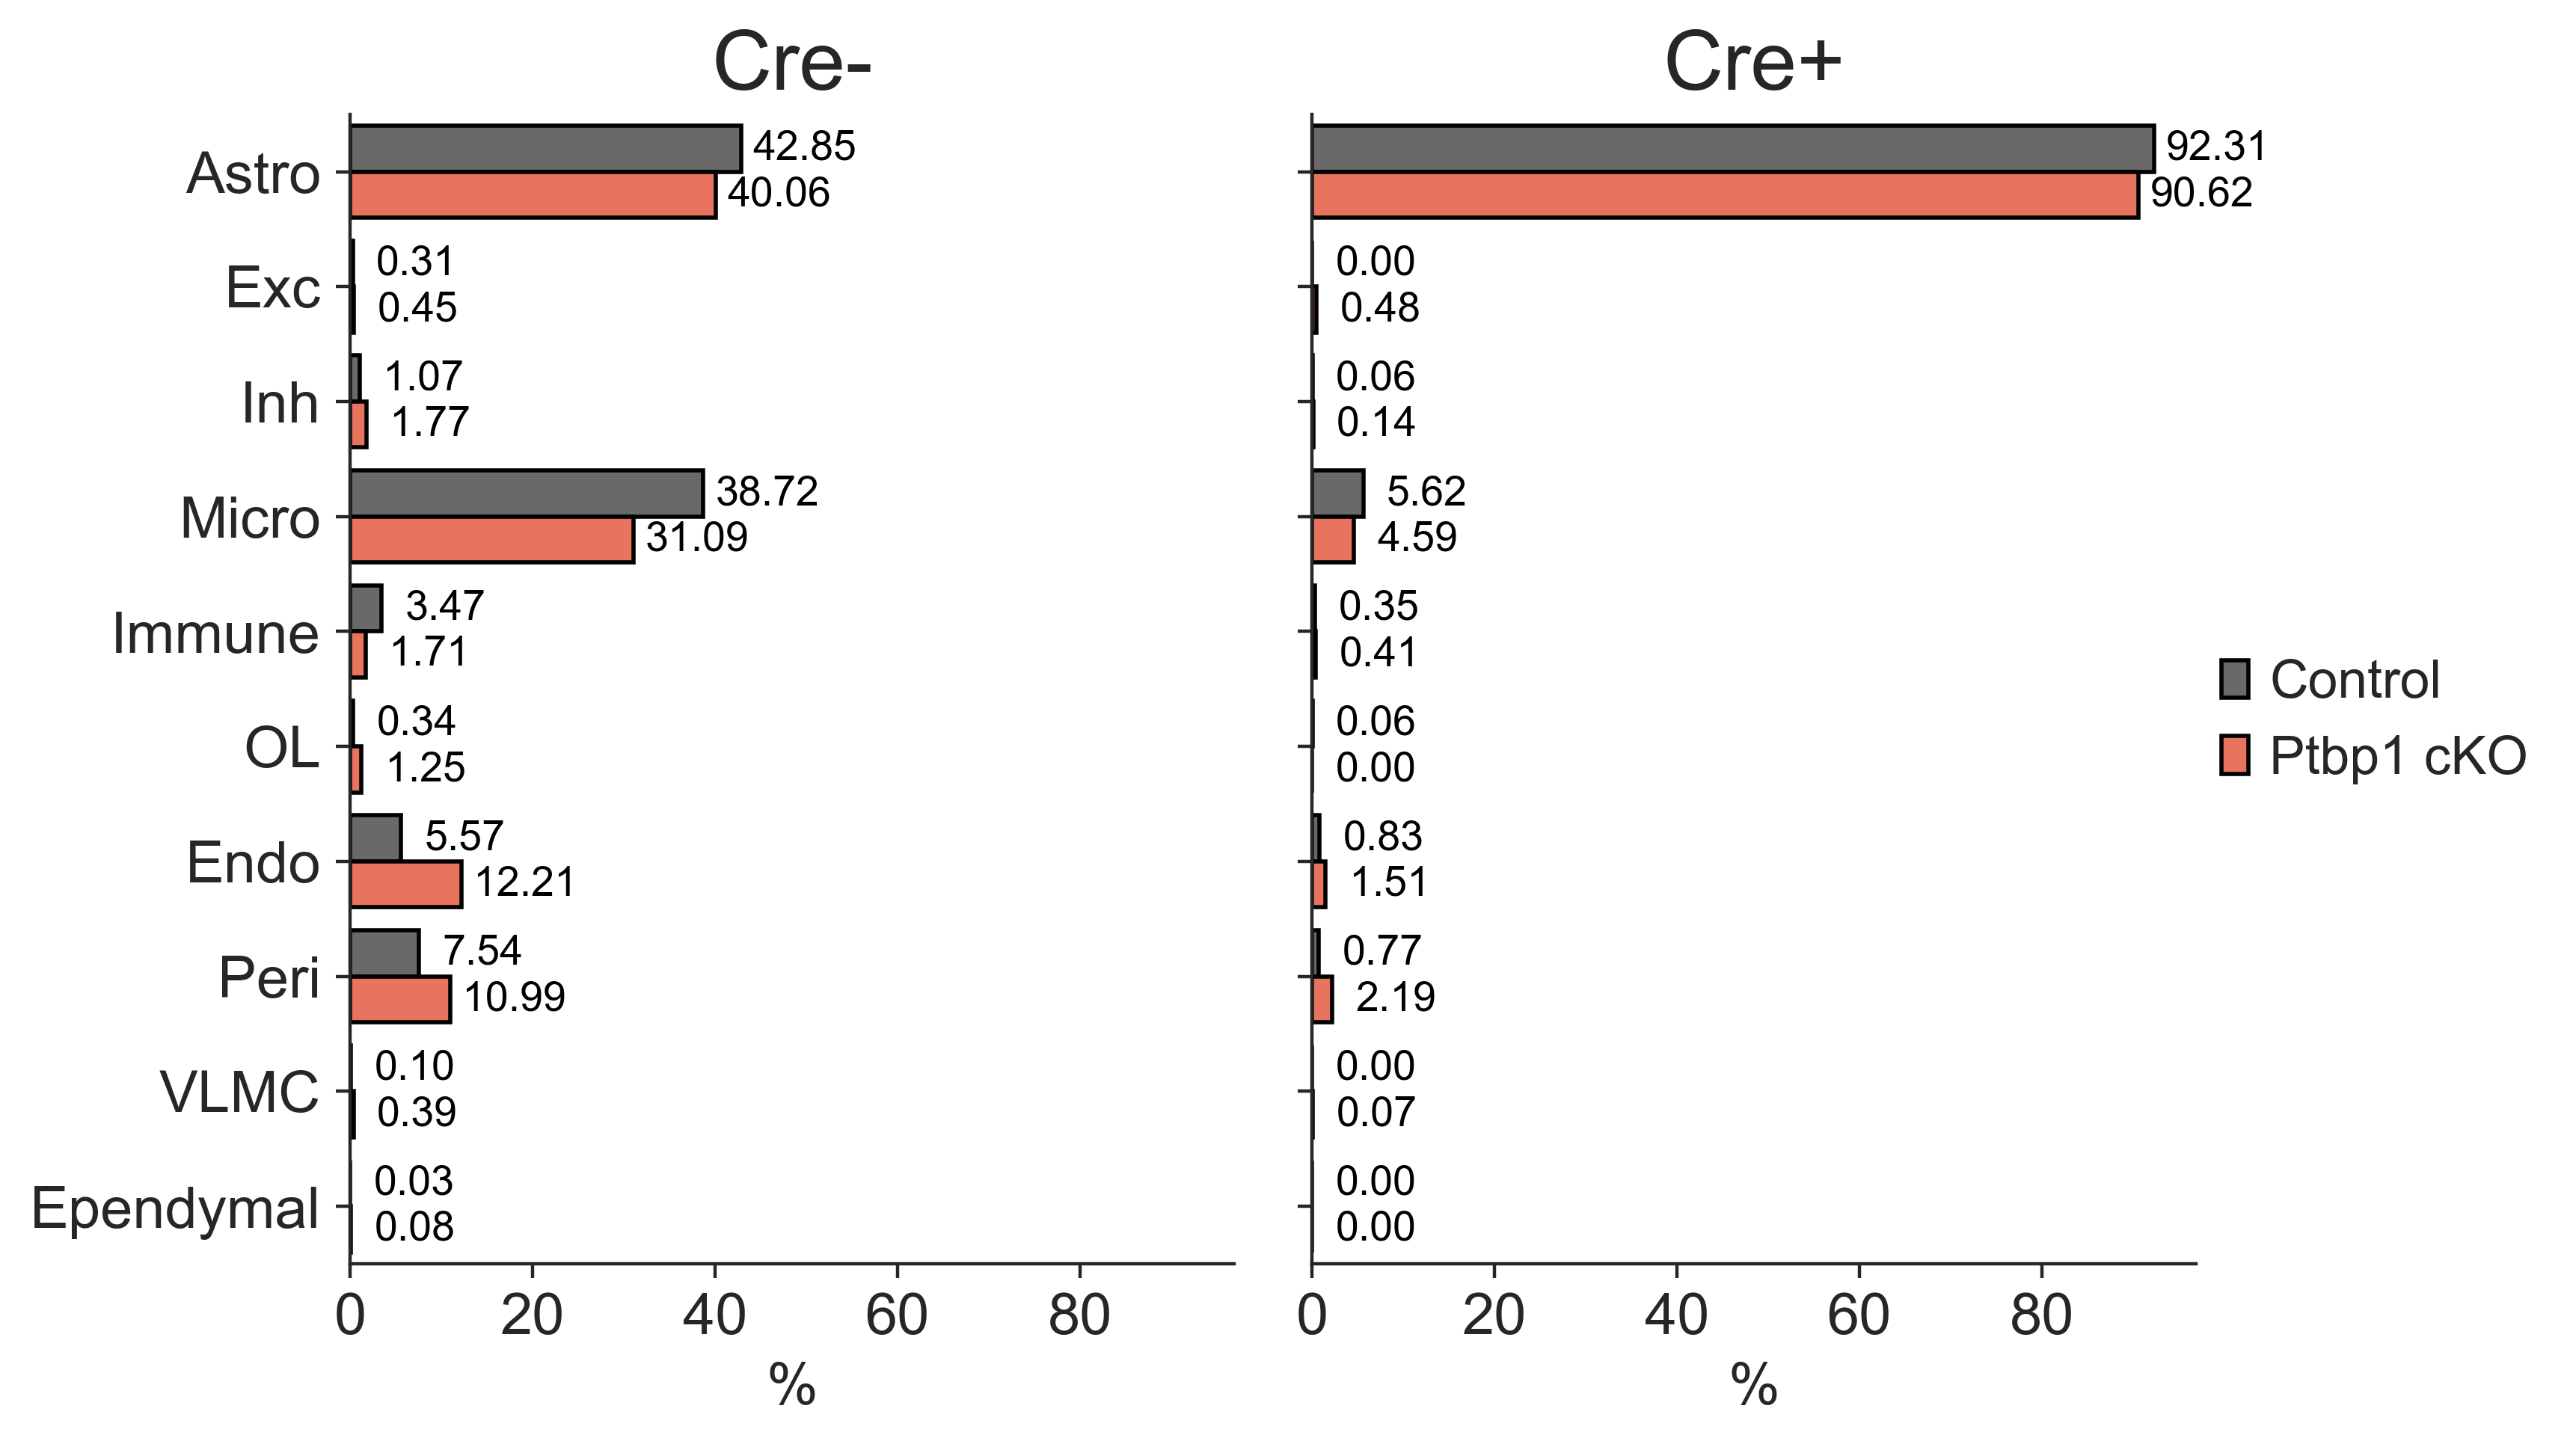

In [41]:
sns.set_style("ticks")
g = sns.catplot(
    data = batch_celltype_size_cre_df,
    y = "cell type",
    order = celltype_palette.keys(),
    x = "proportion",
    hue = "batch",
    hue_order = ["Control", "Ptbp1 cKO"],
    palette = {"Control": "dimgrey", "Ptbp1 cKO": "tomato"},
    kind = "bar",
    linewidth = 1,
    edgecolor = "black",
    col = "Cre_binary",
    col_order = ["Cre-", "Cre+"],
    aspect = 0.8
)
g.set_axis_labels("%", "")
g._legend.set_title(None)
g.set_titles("{col_name}", size = 20)

# Add annotations with an offset for each hue
for ax in g.axes.flat:
    for patch in ax.patches:
        # Get the height and position of each bar
        height = patch.get_width()
        y_position = patch.get_y() + patch.get_height() / 2  # Center the label on the bar

        # Determine the hue from the bar color to adjust the offset
        hue = "Control" if patch.get_facecolor() == (0.41, 0.41, 0.41, 1.0) else "Ptbp1 cKO"  # Using RGB values
        hue_offset = -7 if hue == "Control" else 7  # Adjust left for WT, right for KO

        # Add the annotation
        ax.text(
            height + hue_offset,  # Position with offset
            y_position,  # y position
            f"{height:.2f}",  # Display value with two decimal places
            ha="center", va="center",  # Alignment
            color="black", fontsize=10
        )
plt.savefig(workdir + "/scanpy/figures/celltype_size_cre_WTvsKO.png", dpi = 1000, bbox_inches = "tight")

## Extract subset

### Exc

In [42]:
adata_Exc = adata[adata.obs["cell type"] == "Exc", ] 
adata_neuron = adata[adata.obs["cell type"].isin(["Exc", "Inh"]), ] 

In [43]:
marker_genes_tg_dict

{'Tg': ['cre'],
 'Astro': ['Aldh1l1'],
 'Exc': ['Slc17a7'],
 'Inh': ['Gad1'],
 'Micro': ['Aif1'],
 'Immune': ['Arhgap15'],
 'OL': ['Mbp'],
 'Endo': ['Flt1'],
 'Peri': ['Rgs5'],
 'VLMC': ['Apod'],
 'Ependymal': ['Tmem212']}

In [46]:
Exc_df = pd.DataFrame(
    adata_Exc.raw.X.toarray(),
    index = adata_Exc.raw.obs_names,
    columns = adata_Exc.raw.var_names
)
genes_of_interest = ["cre", "tdtomato", "Aldh1l1", "Slc17a7", "Rbfox3", "Ptbp2"]
Exc_df = Exc_df[genes_of_interest].reset_index()
Exc_df["batch"] = Exc_df["barcode"].map(lambda x: x.split("-")[1]).map(lambda x: "Control" if x == "WT" else "Ptbp1 cKO")
Exc_df["batch_short"] = Exc_df["batch"].map(lambda x: "Ctrl" if x == "Control" else "cKO")
Exc_df["cre_bool"] = Exc_df["cre"].map(lambda x: "Cre+" if x > 0 else "Cre-")
Exc_df["UMAP-1"] = [x[0] for x in adata_Exc.obsm["X_umap"]]
Exc_df["UMAP-2"] = [x[1] for x in adata_Exc.obsm["X_umap"]]
Exc_df["group"] = Exc_df["UMAP-1"].map(lambda x: "Exc-1" if x > 0 else "Exc-2")
# Exc_df = Exc_df.sort_values(["batch", "cre_bool"], ascending = [False, False])

In [47]:
Exc_df

gene_id              barcode       cre  tdtomato   Aldh1l1   Slc17a7  \
0        ACAAGCTAGCGTTGTT-WT  0.000000  1.184126  0.000000  1.482001   
1        ACACTGAAGACATAGT-WT  0.000000  0.000000  0.000000  2.406730   
2        ACCAAACAGGCGCTTC-WT  0.000000  0.000000  0.000000  0.000000   
3        ACGCACGCACTGGATT-WT  0.000000  0.000000  0.000000  0.000000   
4        ACTTAGGTCCCGATCT-WT  0.000000  0.000000  1.615869  0.000000   
..                       ...       ...       ...       ...       ...   
62       TTAGGCAAGATGTTGA-KO  0.000000  1.781418  0.000000  0.000000   
63       TTAGTCTTCCGCATAA-KO  1.111305  1.962200  1.111305  1.111305   
64       TTCCTTCCATTAGGAA-KO  0.000000  0.000000  0.000000  0.000000   
65       TTCTAGTTCATGCCCT-KO  1.273315  1.815697  1.273315  1.815697   
66       TTGCATTCAAAGAACT-KO  0.000000  0.000000  0.000000  1.539372   

gene_id    Rbfox3     Ptbp2      batch batch_short cre_bool    UMAP-1  \
0        1.184126  1.184126    Control        Ctrl     Cre-  5.463093   
1        3.053776  0.000000    Control        Ctrl     Cre-  5.621566   
2        0.000000  0.000000    Control        Ctrl     Cre- -6.621398   
3        0.000000  0.000000    Control        Ctrl     Cre- -6.744265   
4        0.000000  0.000000    Control        Ctrl     Cre- -6.666876   
..            ...       ...        ...         ...      ...       ...   
62       0.000000  1.781418  Ptbp1 cKO         cKO     Cre-  6.081660   
63       0.000000  0.000000  Ptbp1 cKO         cKO     Cre+  6.272714   
64       1.129401  1.129401  Ptbp1 cKO         cKO     Cre-  5.405088   
65       0.000000  0.000000  Ptbp1 cKO         cKO     Cre+  5.966725   
66       2.625814  0.000000  Ptbp1 cKO         cKO     Cre-  5.304221   

gene_id    UMAP-2  group  
0       -7.047786  Exc-1  
1       -6.882666  Exc-1  
2       -2.168203  Exc-2  
3       -2.291345  Exc-2  
4       -2.176733  Exc-2  
..            ...    ...  
62      -6.427561  Exc-1  
63      -6.240350  Exc-1  
64      -7.102473  Exc-1  
65      -6.540789  Exc-1  
66      -7.205157  Exc-1  

[67 rows x 13 columns]

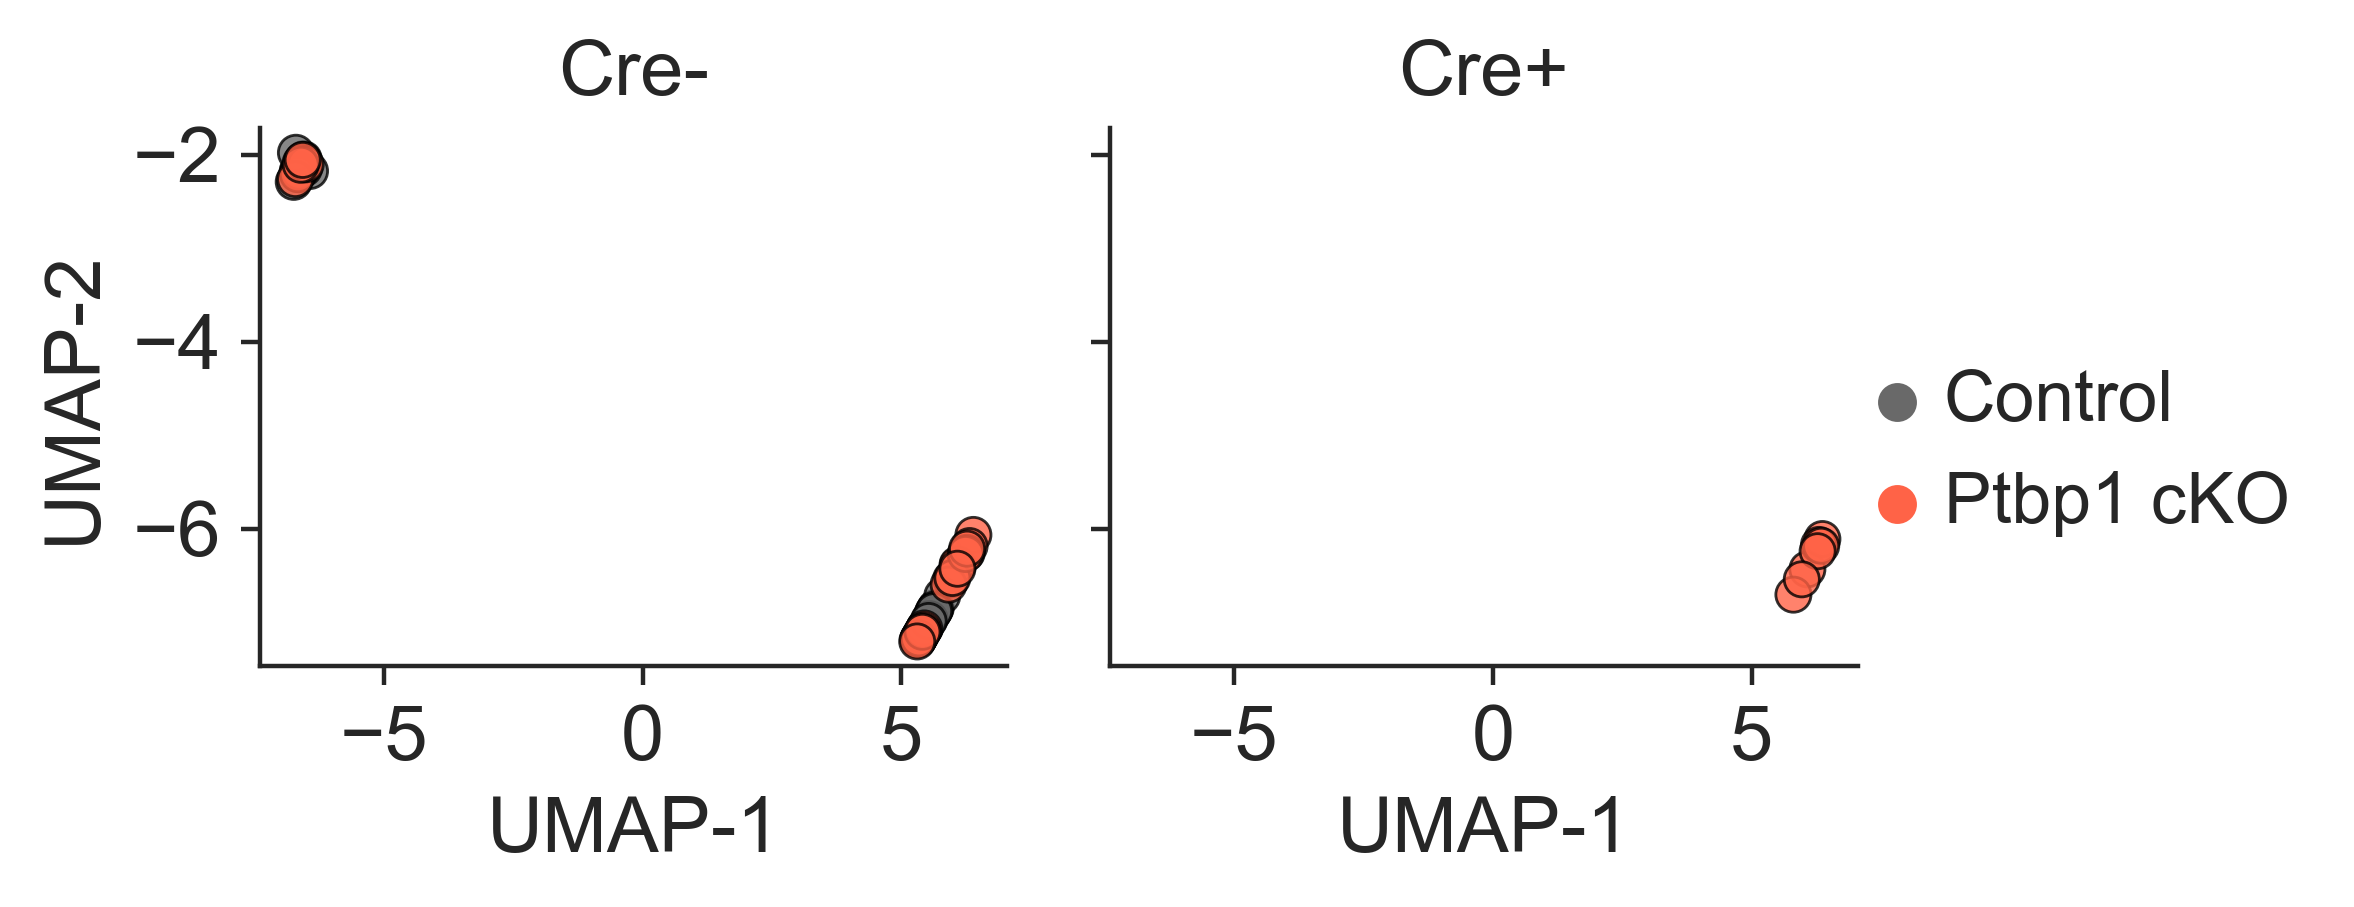

In [48]:
sns.set_style("ticks")
g = sns.relplot(
    data = Exc_df,
    x = "UMAP-1",
    y = "UMAP-2",
    hue = "batch",
    palette = batch_palette,
    col = "cre_bool",
    height = 2.5,
    edgecolor = "black",
    s = 40,
    alpha = 0.8
)
g.set_titles("{col_name}")
g._legend.set_title(None)
plt.savefig(workdir + "/scanpy/figures/Exc_Cre_WTvsKO.png", dpi = 1000, bbox_inches = "tight")

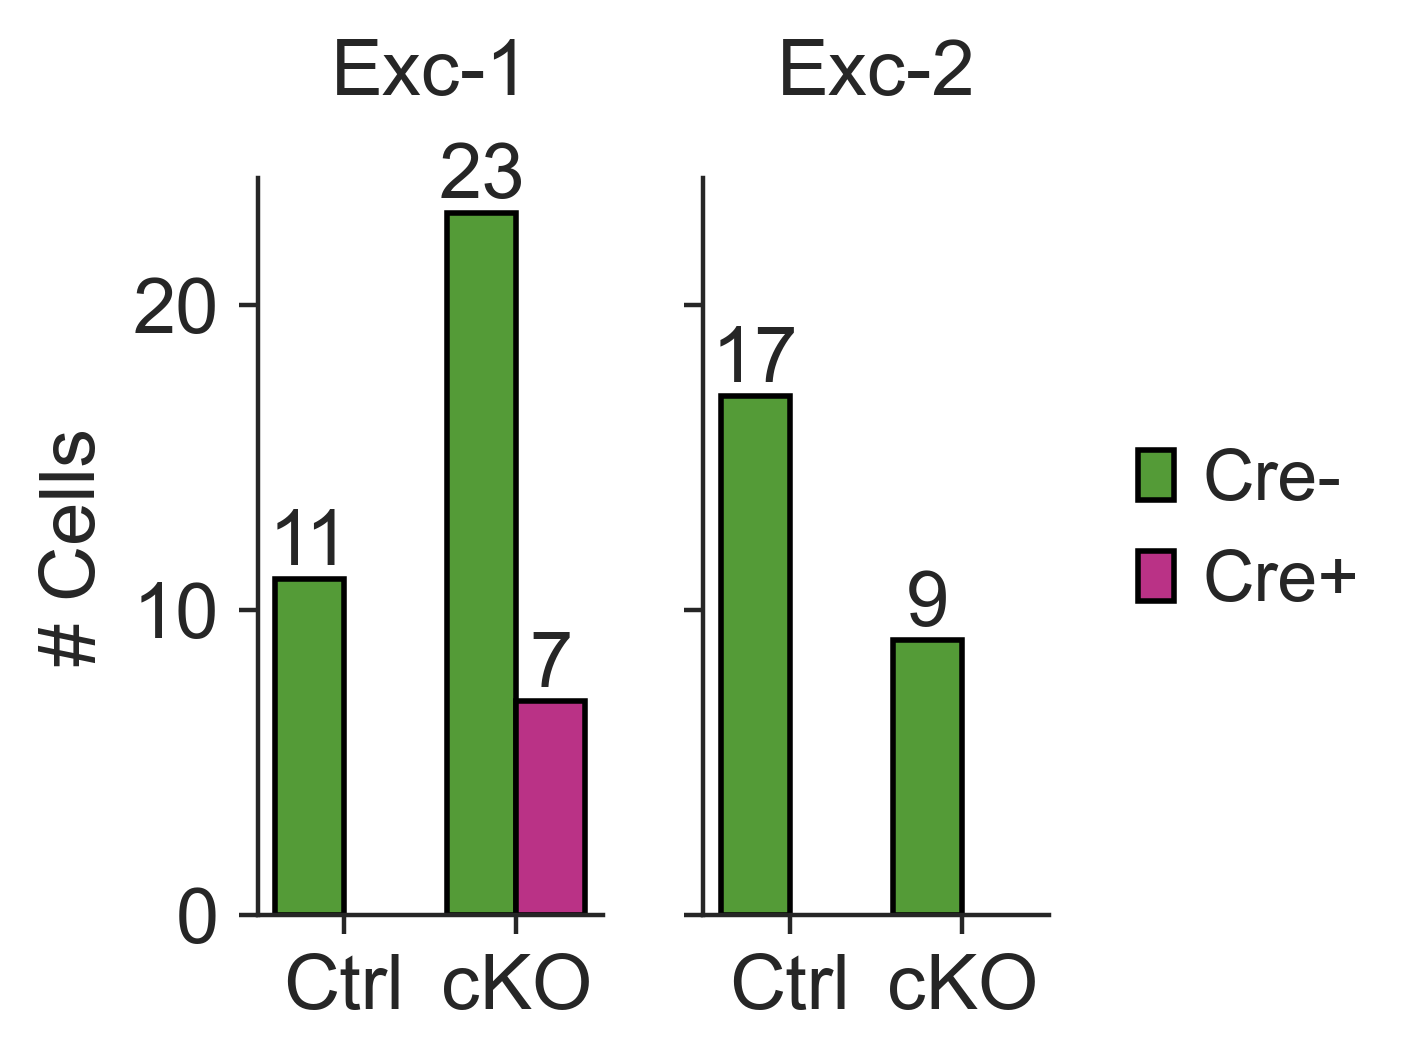

In [49]:
Exc_cre_size_df = Exc_df.groupby(["batch_short", "group", "cre_bool"], as_index = False).size()
g = sns.catplot(
    data = Exc_cre_size_df,
    x = "batch_short",
    order = ["Ctrl", "cKO"],
    y = "size",
    hue = "cre_bool",
    hue_order = ["Cre-", "Cre+"],
    palette = ["#4dac26", "#d01c8b"],
    col = "group",
    kind = "bar",
    linewidth = 1, edgecolor = "black",
    height = 3, aspect = 0.5
)
g.set_titles("{col_name}", pad = 15)
g.set_axis_labels("", "# Cells")
g._legend.set_title(None)
# Add numbers to each bar
for ax in g.axes.flat:
    for bar in ax.containers:
        ax.bar_label(bar, fmt='%.0f', label_type='edge')  # '%.0f' formats the labels as integers
plt.savefig(workdir + "/scanpy/figures/Exc_Cre_WTvsKO_bar.png", dpi = 1000, bbox_inches = "tight")